# Methodology: Dataset Curation and IDK Integration

The experiments in this project are based on the Modified National Institute of Standards and Technology (MNIST) handwritten digits dataset. All dataset manipulation, curation, and analysis were conducted using FiftyOne, PyTorch, and FiftyOne Brain. The full pipeline spans dataset preparation, automated data diagnostics, the introduction of an IDK (I-Don’t-Know) class, and the construction of datasets for training both a standard 10-class model and an uncertainty-aware 11-class model.

1. Dataset Loading: The official MNIST train and test splits were imported directly from the FiftyOne Dataset Zoo.
2. Deterministic Splitting: The original 60,000-sample training split was divided into an 85% training subset (51,000 samples) and a 15% validation subset (9,000 samples) using a fixed random seed to ensure reproducibility.
3. Baseline Model Training: A modernized LeNet-5 architecture was trained from scratch in PyTorch. The best-performing checkpoint was selected based on validation loss.
4. Model-Based Diagnostics: The trained LeNet-5 model was applied to the training data to surface misclassified, uncertain, or otherwise suspicious samples.

---
**Adjusted Flow for creating IDK-Model:**

5. Automated Data Analysis: FiftyOne Brain metrics—including embeddings, hardness, mistakenness, and uniqueness—were computed to identify sources of ambiguity and potential annotation errors. Samples flagged as non-digit, ambiguous, or inconsistent were either removed or relabeled as IDK.
6. Targeted Augmentation: Samples that were very representative, samples that were rare but valid (correct label, but hard or unique) and a small set of idk-labelled data were identified as augmentation seeds to improve generalization to uncommon handwriting styles.
7. Consistent IDK Strategy: The same curation logic was applied to both the validation and test splits to obtain clean and ambiguity-aware evaluation datasets.
8. IDK Model Construction: Two uncertainty-aware models were trained:
* an 11-class classifier (digits 0–9 + explicit IDK), and
* a fine-tuned 11-class identifier on the previous 10-class model
* future: include a binary IDK detector (a two-head model predicting both digit class and IDK ∈ {0,1})).
9. IDK Model Training:
* To initialize the 11-class model (digits + IDK), the LeNet-10 backbone was fine-tuned deliberately just on the augmented dataset rather than the full training set.
* Active-Learning Procedure: After the initial 11-class warm-start, the training process switched to an iterative active-learning loop. In each round, the current model was applied to the curated training set, and FiftyOne Brain metrics (hardness, mistakenness, uniqueness, representativeness) were recomputed.
10. Evaluation: Both IDK-enhanced models were evaluated on the curated test set and compared against the baseline 10-class LeNet-5 model using a set of targeted research questions focused on accuracy, uncertainty calibration, IDK quality, and selective classification performance.



## Identifying misclassified or ambiguous sample cases

**Ambiguity Categories for Dataset Curation**

To improve MNIST data quality and build a meaningful IDK (“I don’t know”) class, I categorize samples into four diagnostic groups using model-derived metrics (**hardness, confidence, mistakenness, uniqueness**) and l**ocal neighborhood consistency** in embedding space. Each group highlights a distinct type of ambiguity or data issue relevant for curation.

Normally, these **thresholds** would be set more **broadly** to support a **human-in-the-loop** curation workflow where ambiguous cases are manually reviewed. Since I intentionally skip manual inspection in favor of experimenting with automated criteria, I apply **tighter, more selective thresholds** so that the four categories trigger **clear, deterministic actions without human intervention**.

1. **Likely mislabels**

What it captures:
Samples where the model is **highly confident, yet its prediction disagrees** with the ground-truth, and the embedding-space **neighbors form a strong consensus supporting the model's label**.

Why it matters:
These cases reveal **likely annotation errors**. Correcting or **removing** these **mislabels** improves dataset reliability and produces cleaner training signals.

Action:
* Manual Review: Correct label or remove
* Option - Automatically: Remove the most obvious cases based on a threshold and relabel the rest as *IDK*

2. **Non-digit candidates**

What it captures:
Samples that are **highly unusual, very hard, or low-confidence**, and whose **embedding-space neighbors do not agree on a consistent class**. These include distorted digits, corrupted images, or symbols that resemble digits only loosely.

Why it matters:
These samples behave like “out-of-distribution” inputs and are strong candidates for the **IDK class or even removal**. Explicitly labeling them as IDK improves model robustness and uncertainty handling.

Action:
* Manual Review: prune if no consistent decision on ground-truth label can be reached
* Option - Automatically: relabel as *IDK*


3. **Ambiguous disagreements**

What it captures:
Samples where the **model disagrees** with the label **but shows low confidence or high hardness**, and the **disagreement is not strong enough** to be labeled as a mislabel.

Why it matters:
These represent **genuine ambiguities** (e.g., 4 vs. 9, 3 vs. 5). They are **ideal candidates for the IDK category**, because even humans might struggle to classify them. Explicitly modeling this ambiguity teaches the classifier to abstain when appropriate.

Action: Relabel as *IDK*

4. **Ambiguous matches for augmentation (“clean but rare”)**

What it captures:
Samples that are **correctly classified** but still exhibit **high hardness, uniqueness, or low confidence**, while the **local neighborhood in embedding space consistently supports the same label**.

Why it matters:
These are **rare but valid** handwriting styles that the model finds difficult because they are **underrepresented**. Therefore, they are ideal **candidates for targeted augmentation**, which expands their local manifold and improves the **model's ability to generalize** to uncommon digit variations.

Action: Use as augmentation dataset


This project takes inspiration from key ideas in [Confident Learning](https://arxiv.org/abs/1911.00068) *by Curtis G. Northcutt et al.*, a framework for automatically detecting label noise.

Implemented ideas from Confident Learning:
* use of high-confidence disagreements to flag suspected mislabels
* analysis of prediction probabilities and hardness (entropy)
* use of embedding-space neighborhood consistency to validate errors
* ranking ambiguous samples based on multiple uncertainty signals

What is not implemented:
* computing the full confident joint matrix
* estimating the label-noise transition matrix
* confidence-adjusted error rate estimation across classes

Reason for omission:
These steps require repeated large-batch inference and matrix estimation, which are GPU-intensive and were excluded due to resource constraints.

## Handling Class Imbalance

The identified samples for data augmentation would have introduced a strong imbalance (up to **3–4×** differences between classes). Therefore, the following steps were applied:

* **Balanced augmentation set:** Overrepresented digit classes in dataset_to_augment were reduced so that only the IDK class remained a minority class.
* **Weighted sampling:** The DataLoader used a **WeightedRandomSampler** with inverse class-frequency weights to oversample minority classes during training.
* **Weighted loss:** **CrossEntropyLoss** was configured with class weights to further compensate for remaining imbalance.
* **Capped IDK weight:** The IDK class weight was intentionally capped to prevent it from overpowering the loss function.

## IDK Modeling Approaches

To incorporate explicit uncertainty handling into the classifier, I evaluate two complementary IDK modeling strategies:

1. **Binary IDK detector (two-head / mutlilabel model):**
A second classification head is added on top of the shared embedding:
* Head 1: predicts the digit class (0–9)
* Head 2: predicts whether a sample should be labeled IDK ∈ {0,1}

  --> This separates *digit recognition* from *ambiguity detection*.

2. **11-class classifier (IDK as an additional digit class):**
The classifier output is expanded to 11 classes, with IDK treated as its own label alongside digits 0–9.
This model learns IDK as a true semantic category, not just low confidence.

This requires careful curation of ambiguous samples and class-imbalance handling, since IDK is naturally much rarer.

## Active Learning Cycle

**Active-Learning Procedure:**
After the initial 11-class warm-start, the training process switched to an iterative active-learning loop. In each round, the current model was applied to the curated training set, and FiftyOne Brain metrics (hardness, mistakenness, uniqueness, representativeness) were recomputed. These signals identified new non-digit candidates, ambiguous disagreements, and rare but valid examples.
Each round consisted of:
1. Inference: apply the current 11-class model to all curated train samples
2. Analysis: recompute uncertainty and embedding-based metrics
3. Selection: identify IDK candidates, mislabels, and augmentation candidates
4. Curation: update IDK labels and remove severe errors
5. Retraining: fine-tune the model on the newly curated dataset

Evaluation: applies the same inference step to the frozen validation set to monitor:
* digit accuracy
false-IDK rate
IDK precision/recall

## Evaluation on test data

To guide this evaluation, I formulated a set of research questions that target both core objectives of the project: better uncertainty handling and better data curation.

**Question:** Does introducing a supervised IDK class, learned from curated ambiguous samples, improve both (1) uncertainty-aware prediction and (2) the ability to identify new ambiguous samples during further dataset curation, compared to a standard 10-class model?


**Goal** is
1.   Better predictive uncertainty
2.   Better data curation (IDK model helps find new ambiguous samples)


**Sub-questions:**
1.   If both models **must output a digit** for every test sample, which model is **more accurate**, and is the improvement consistent across classes?
2.   Does the IDK model fail more gracefully than the 10-class model by **abstaining on uncertain samples**?
3. When the IDK model says “IDK” is it **actually identifying true ambiguous samples**? Does it do this better than the 10-class model's low-confidence cases?
4. On samples identified as hard/mistaken/unique by the baseline model,
does the 11-class model **use IDK to avoid incorrect confident predictions**?



## Handling iterative curation with non-persistent Sample IDs

FiftyOne assigns **new sample IDs** every time a dataset is recreated or loaded in a fresh session. To overcome this problem, I designed the entire curation pipeline to track samples by their **absolute filepaths** rather than by their ephemeral IDs. Since filepaths remain stable across sessions, this allows all curated subsets—mislabels, ambiguous samples, IDK candidates, and augmentation seeds—to be reconstructed reliably at any time.

## Future Extensions

Several improvements could further improve the IDK modeling and quality of the MNIST dataset:

1. **Threshold Optimization**

The current hardness, mistakenness, uniqueness, and confidence thresholds could be treated as **tunable hyperparameters**, optimized via grid search or Bayesian methods.

2. **Improved Similarity Modeling**

Using richer embeddings or clustering could lead to more accurate detection of subtle handwriting variants and mislabeled digits.

3. **Ensemble-Based Mislabel Detection**

By comparing predictions from multiple independently trained models, mislabeled or ambiguous samples can be identified more reliably, since consistent model disagreement often signals annotation errors or uncertainty hotspots.

# Preparation

## 1. Setup / Imports

In [1]:
%%capture
!uv pip install fiftyone==1.7.0 torch==2.6.0 torchvision==0.21 numpy==2.0.2 open-clip-torch==3.2.0

In [2]:
# Check installed versions
import fiftyone
import torch
import torchvision
import numpy
import open_clip

/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


In [3]:
# Plug-in to evaluate the performance of our classification models
!fiftyone plugins download \
    https://github.com/voxel51/fiftyone-plugins \
    --plugin-names @voxel51/evaluation


Copying plugin '@voxel51/evaluation' to '/root/fiftyone/__plugins__/@voxel51/evaluation'


In [4]:
# Plug-in for image augmentations
!fiftyone plugins download https://github.com/jacobmarks/fiftyone-albumentations-plugin


Copying plugin '@jacobmarks/albumentations_augmentation' to '/root/fiftyone/__plugins__/@jacobmarks/albumentations_augmentation'


## Imports

In [5]:
import os

# Set environment variables for reproducibility BEFORE importing torch
os.environ['PYTHONHASHSEED'] = '51'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torchvision.transforms.v2 as transforms
from torch.optim import Adam
from torch.utils.data import Dataset, ConcatDataset

import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob

from fiftyone import ViewField as F
import fiftyone.utils.random as four
from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
# import gc
import albumentations as A
import cv2
import random
from typing import Optional, Dict, Tuple, Any
from collections import defaultdict, Counter

from typing import Iterable
import json

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    precision_recall_fscore_support,
    confusion_matrix,
)

In [6]:
# define constants
SEED = 51
NUM_CLASSES = 10
NUM_CLASSES_IDK = 11

STORAGE_PATH = "/content/drive/MyDrive/Colab Notebooks/Applied Computer Vision Projects/Project01"

## Reproducibility

In [7]:
def set_seeds(seed=SEED):
    """
    Set seeds for complete reproducibility across all libraries and operations.

    Args:
        seed (int): Random seed value
    """
    # Set environment variables before other imports
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch GPU (all devices)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

        # CUDA deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # OpenCV
    cv2.setRNGSeed(seed)

    # Albumentations (for data augmentation)
    try:
        A.seed_everything(seed)
    except AttributeError:
        # Older versions of albumentations
        pass

    # PyTorch deterministic algorithms (may impact performance)
    try:
        torch.use_deterministic_algorithms(True)
    except RuntimeError:
        # Some operations don't have deterministic implementations
        print("Warning: Some operations may not be deterministic")

    print(f"All random seeds set to {seed} for reproducibility")



# Usage: Call this function at the beginning and before each training phase
set_seeds(SEED)

# Additional reproducibility considerations:

def create_deterministic_training_dataloader(dataset, batch_size, shuffle=True, **kwargs):
    """
    Create a DataLoader with deterministic behavior.

    Args:
        dataset: PyTorch Dataset instance
        batch_size: Batch size
        shuffle: Whether to shuffle data
        **kwargs: Additional DataLoader arguments

    Returns:
        Training DataLoader with reproducible behavior
    """
    # Use a generator with fixed seed for reproducible shuffling
    generator = torch.Generator()
    generator.manual_seed(51)

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        generator=generator if shuffle else None,
        **kwargs
    )

# Example usage:
# train_loader = create_deterministic_dataloader(
#     torch_train_set,
#     batch_size=64,
#     shuffle=True,
#     num_workers=4,
#     pin_memory=True
# )



All random seeds set to 51 for reproducibility


## Save Results

In [8]:
# Make sure the model is on the correct device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# Gives Colab access to Google Drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Define the path to save results on local hard-drive
ROOT = Path(STORAGE_PATH)

# Put all models in a subfolder
CKPT_DIR = ROOT / "models"
CKPT_DIR.mkdir(exist_ok=True)

# Put all found filepaths of samples in a subfolder
DATA_DIR = ROOT / "filepaths"
DATA_DIR.mkdir(exist_ok=True)

In [11]:
def get_ids_from_filepaths(dataset, filepaths):
  samples = dataset.match(F("filepath").is_in(filepaths))
  ids = [s.id for s in samples]

  return ids


def get_filepaths_from_ids(dataset, ids):
  filepaths = dataset.select(ids).values("filepath")

  return filepaths

In [12]:
save_filepaths_to_drop = DATA_DIR/"filepaths_to_drop.json"
save_filepaths_to_relabel = DATA_DIR/"filepaths_to_relabel.json"

def load_log(path: Path):
    if path.exists():
        return json.loads(path.read_text())
    return []

def save_log(filepaths, path: Path):
    path.write_text(json.dumps(list(filepaths), indent=2))

def append_filepaths_to_log(path: Path, new_filepaths):
    stored = load_log(path)

    # dedupe while preserving order
    existing = set(stored)
    for fp in new_filepaths:
        if fp not in existing:
            stored.append(fp)
            existing.add(fp)

    save_log(stored, path)

In [13]:
def get_filepaths_from_log(log_path):
    stored = load_log(log_path)
    # just in case, dedupe again
    return list(dict.fromkeys(stored))

In [14]:
from fiftyone import ViewField as F

def get_ids_from_log(dataset, log_path):
    fps = get_filepaths_from_log(log_path)
    if not fps:
        return []

    view = dataset.match(F("filepath").is_in(fps))
    ids = view.values("id")
    fp_view = view.values("filepath")

    # map filepaths → IDs
    fp_to_id = dict(zip(fp_view, ids))

    # preserve original log order, skip missing
    return [fp_to_id[fp] for fp in fps if fp in fp_to_id]


# Create Baseline Model

In [15]:
# Alternative modern version with ReLU and MaxPooling
class ModernLeNet5(nn.Module):
    """
    Modernized version of LeNet-5 with ReLU activations and max pooling.
    Often performs better on MNIST than the original version.
    """

    def __init__(self, num_classes):
        super(ModernLeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(Fun.relu(self.conv1(x)))
        x = self.pool(Fun.relu(self.conv2(x)))
        x = Fun.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = Fun.relu(self.fc1(x))
        x = self.dropout(x)  # Add dropout for regularization
        x = self.fc2(x)

        return x


In [16]:
# We use the training split to train our LeNet model
# We make this dataset persistent as we want to save our changes for multiple sessions
train_val_dataset = foz.load_zoo_dataset("mnist",
                                         split='train',
                                         dataset_name="mnist-train-val",
                                         persistent=True)

train_val_dataset.compute_metadata()

# The images come with the 'train' tag and this must be deleted
# at the sample level.
train_val_dataset.untag_samples(["train", "validation"])

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/mnist/train'
100%|██████████| 9.91M/9.91M [00:00<00:00, 16.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 456kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.57MB/s]

   0% |/------------|   168/60000 [108.7ms elapsed, 38.7s remaining, 1.5K samples/s] 

 100% |█████████████| 60000/60000 [32.6s elapsed, 0s remaining, 2.4K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 60000/60000 [32.6s elapsed, 0s remaining, 2.4K samples/s]      


Dataset info written to '/root/fiftyone/mnist/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/mnist/info.json'


Loading 'mnist' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'mnist' split 'train'


 100% |█████████████| 60000/60000 [38.0s elapsed, 0s remaining, 1.7K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 60000/60000 [38.0s elapsed, 0s remaining, 1.7K samples/s]      


Dataset 'mnist-train-val' created


INFO:fiftyone.zoo.datasets:Dataset 'mnist-train-val' created


Computing metadata...


INFO:fiftyone.core.metadata:Computing metadata...


 100% |█████████████| 60000/60000 [24.3s elapsed, 0s remaining, 2.6K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 60000/60000 [24.3s elapsed, 0s remaining, 2.6K samples/s]      


In [17]:
# We list the datasets that we have available on this session.
fo.list_datasets()

['mnist-train-val']

In [18]:
set_seeds(SEED)

train_split = 0.85
val_split = 0.15

# Create random 85%/15% split using tags
four.random_split(train_val_dataset,
                  {"train": train_split, "validation": val_split},
                  # The seed makes the split reproducible
                  seed=SEED)

# Verify the split by counting tags
tag_counts = train_val_dataset.count_sample_tags()
print("Tag counts after split:")
print(tag_counts)

train_name = "mnist-training-set"
val_name   = "mnist-validation-set"

# --- TRAIN ---
if train_name not in fo.list_datasets():
  train_dataset = train_val_dataset.match_tags("train").clone(name=train_name)
  print(f"Cloned train view into dataset: {train_name} (len={len(train_dataset)})")
else:
  train_dataset = fo.load_dataset(train_name)

# --- VALIDATION ---
if val_name not in fo.list_datasets():
  val_dataset = train_val_dataset.match_tags("validation").clone(name=val_name)
  print(f"Cloned validation view into dataset: {val_name} (len={len(val_dataset)})")
else:
  val_dataset = fo.load_dataset(val_name)

# Define persistency
train_dataset.persistent = True
val_dataset.persistent = True

# Verify no overlap between train and validation
train_ids = set(train_dataset.values("id"))
val_ids = set(val_dataset.values("id"))
overlap = train_ids.intersection(val_ids)

All random seeds set to 51 for reproducibility
Tag counts after split:
{'train': 51000, 'validation': 9000}
Cloned train view into dataset: mnist-training-set (len=51000)
Cloned validation view into dataset: mnist-validation-set (len=9000)


In [19]:
session = fo.launch_app(train_dataset, auto=False)

Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.



Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.7.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.7.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



In [20]:
# Custom PyTorch Dataset class for MNIST training data
class CustomTorchImageDataset(torch.utils.data.Dataset):
    def __init__(self, fiftyone_dataset,
                 image_transforms=None,
                 label_map=None,
                 gt_field="ground_truth"):
        self.fiftyone_dataset = fiftyone_dataset
        self.image_paths = self.fiftyone_dataset.values("filepath")
        self.str_labels = self.fiftyone_dataset.values(f"{gt_field}.label")
        self.image_transforms = image_transforms

        if label_map is None:
            self.label_map = {str(i): i for i in range(10)}  # "0"->0, "1"->1, etc.
        else:
            self.label_map = label_map

        print(f"CustomTorchImageDataset initialized with {len(self.image_paths)} samples.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('L')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return torch.randn(1, 28, 28), torch.tensor(-1, dtype=torch.long)

        if self.image_transforms:
            image = self.image_transforms(image)

        label_str = self.str_labels[idx]
        label_idx = self.label_map.get(label_str, -1)
        if label_idx == -1:
            print(f"Warning: Label '{label_str}' not in label_map for image {image_path}")

        return image, torch.tensor(label_idx, dtype=torch.long)

In [21]:
def compute_stats_fiftyone(fiftyone_view):
    """
    Compute stats directly from FiftyOne using aggregations.
    Requires images to be loaded as arrays.
    """

    print("Computing image intensity statistics from FiftyOne view...")

    # Get all image filepaths
    filepaths = fiftyone_view.values("filepath")

    # Load all pixel values
    all_pixels = []

    for filepath in tqdm(filepaths):

        try:
            # Load image as grayscale array
            image = Image.open(filepath).convert('L')
            # Scale values to the range [0, 1]
            pixels = np.array(image, dtype=np.float32) / 255.0
            all_pixels.append(pixels.flatten())
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            continue

    # Concatenate all pixel values
    all_pixels = np.concatenate(all_pixels)

    # Compute statistics
    mean = np.mean(all_pixels)
    std = np.std(all_pixels)

    print(f"Computed from {len(filepaths)} images")
    print(f"Total pixels: {len(all_pixels):,}")

    return mean, std

mean_intensity, std_intensity = compute_stats_fiftyone(train_dataset)
f"Mean: {mean_intensity:.4f}, Std: {std_intensity:.4f}"

Computing image intensity statistics from FiftyOne view...


100%|██████████| 51000/51000 [00:10<00:00, 4914.15it/s]


Computed from 51000 images
Total pixels: 39,984,000


'Mean: 0.1318, Std: 0.3075'

In [22]:
# We obtain the distinct labels of the dataset
dataset_classes = sorted(train_dataset.distinct("ground_truth.label"))

# Map the string labels to numerical values (we need this for the PyTorch dataset)
label_map = {string_label: index for index, string_label in enumerate(dataset_classes)}

In [23]:
image_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((mean_intensity,), (std_intensity,))
])

In [24]:
torch_train_set = CustomTorchImageDataset(train_dataset,
                                          label_map=label_map,
                                          image_transforms=image_transforms)

CustomTorchImageDataset initialized with 51000 samples.


In [25]:
torch_val_set = CustomTorchImageDataset(val_dataset,
                                     label_map=label_map,
                                     image_transforms=image_transforms)

CustomTorchImageDataset initialized with 9000 samples.


In [26]:
# Define batch size
batch_size = 64
num_workers = os.cpu_count()  # Number of CPU cores

In [27]:
train_loader = create_deterministic_training_dataloader(
    torch_train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

In [28]:
val_loader = torch.utils.data.DataLoader(
    torch_val_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)

print("Train and validation DataLoaders created successfully.")
print(f"Train DataLoader has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")

Train and validation DataLoaders created successfully.
Train DataLoader has 797 batches.
Validation DataLoader has 141 batches.


In [29]:
# Runs one training epoch: forward pass, loss, backprop, and weight updates
def train_epoch(model, train_loader, loss_fn, optimizer):
  batch_losses = []
  model.train()
  for images, labels in tqdm(train_loader, desc="Training: "):
      #import pdb; pdb.set_trace()

      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = loss_fn(logits, labels)
      # Clear gradients from previous iteration (PyTorch accumulates by default)
      optimizer.zero_grad()
      # Computes the gradients with backpropagation
      loss_value.backward()
      # Updates the weights
      optimizer.step()

      batch_losses.append(loss_value.item())

  train_loss = np.mean(batch_losses)
  return train_loss


In [30]:
# Evaluates the model for one epoch on the validation set (no gradients)
def val_epoch(model, val_loader, loss_fn):
  batch_losses = []
  model.eval()
  with torch.inference_mode():
    for images, labels in tqdm(val_loader, desc="Validation: "):
      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = loss_fn(logits, labels)
      batch_losses.append(loss_value.item())
  val_loss = np.mean(batch_losses)
  return val_loss

In [31]:
# Trains the model for multiple epochs, tracks validation loss, and saves the best checkpoint
def train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs, model_save_path):
  train_losses = []
  val_losses = []

  best_val_loss = float('inf')
  best_model = None

  for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer)
    val_loss = val_epoch(model, val_loader, loss_fn)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        # Save the best model
        torch.save(best_model.state_dict(), model_save_path)
        print('Found and saved better weights for the model')

  return train_losses, val_losses

In [32]:
# define where best model should be saved
model_save_path = CKPT_DIR / "lenet10_mnist.pth"

In [33]:
# Sets up the LeNet model, loss, optimizer, and trains it for the specified epochs
lenet_model = ModernLeNet5(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()

lr=0.003
betas=(0.9, 0.999)
eps=1e-08
weight_decay=0
num_epochs = 10

# Define the optimizer (variant of stochastic gradient descent)
optimizer = Adam(lenet_model.parameters(),
                 lr=lr, betas=betas,
                 eps=eps, weight_decay=weight_decay)

# Ensure reproducibility for the training process
set_seeds(SEED)

train_losses = []
val_losses = []

print(f"Starting training for {num_epochs} epochs...")
train_losses, val_losses = train_model(lenet_model, train_loader, val_loader, optimizer, criterion, num_epochs, model_save_path)



All random seeds set to 51 for reproducibility
Starting training for 10 epochs...


Validation: 100%|██████████| 141/141 [00:03<00:00, 37.44it/s]


Epoch 1/10 - Train Loss: 0.2165 - Val Loss: 0.0824
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 42.70it/s]


Epoch 2/10 - Train Loss: 0.0795 - Val Loss: 0.0575
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 43.36it/s]


Epoch 3/10 - Train Loss: 0.0624 - Val Loss: 0.0526
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 42.06it/s]


Epoch 4/10 - Train Loss: 0.0547 - Val Loss: 0.0544


Validation: 100%|██████████| 141/141 [00:05<00:00, 28.00it/s]


Epoch 5/10 - Train Loss: 0.0485 - Val Loss: 0.0548


Validation: 100%|██████████| 141/141 [00:04<00:00, 30.32it/s]


Epoch 6/10 - Train Loss: 0.0421 - Val Loss: 0.0577


Validation: 100%|██████████| 141/141 [00:03<00:00, 42.47it/s]


Epoch 7/10 - Train Loss: 0.0385 - Val Loss: 0.0642


Validation: 100%|██████████| 141/141 [00:03<00:00, 42.50it/s]


Epoch 8/10 - Train Loss: 0.0394 - Val Loss: 0.0588


Validation: 100%|██████████| 141/141 [00:03<00:00, 42.29it/s]


Epoch 9/10 - Train Loss: 0.0359 - Val Loss: 0.0646


Validation: 100%|██████████| 141/141 [00:03<00:00, 37.40it/s]

Epoch 10/10 - Train Loss: 0.0334 - Val Loss: 0.0551


In [34]:
# Plots training and validation loss curves and marks the best validation epoch
def plot_losses(train_losses, val_losses, epochs):
    epochs = np.arange(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))

    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    best_epoch = int(np.argmin(val_losses) + 1)         # 1-based
    plt.axvline(x=best_epoch, color='red', linestyle='--',
                label=f'Best Val Loss Epoch {best_epoch}')

    plt.legend()
    plt.show()

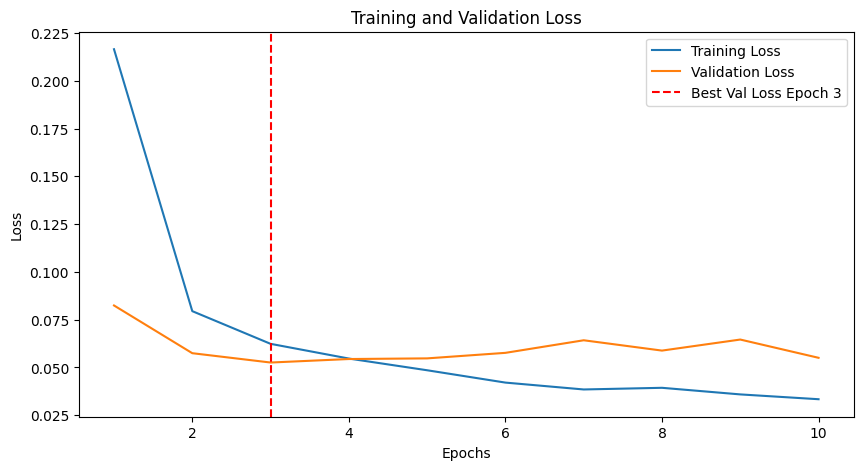

In [35]:
plot_losses(train_losses, val_losses, num_epochs)

In [36]:
# Loads a saved LeNet checkpoint and moves it to the active device
def load_lenet_model(model_save_path, num_classes):
  loaded_model = ModernLeNet5(num_classes)
  loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))
  loaded_model = loaded_model.to(device)

  print(f"Model loaded successfully from {model_save_path}")
  print(f"Model is on device: {next(loaded_model.parameters()).device}")

  return loaded_model

In [37]:
# Load the best validation model for evaluation on test set
lenet10_model = load_lenet_model(model_save_path, NUM_CLASSES)

# Set the model to evaluation mode
lenet10_model.eval()

print(f"Model loaded successfully from {model_save_path}")
print(f"Model is on device: {next(lenet10_model.parameters()).device}")

Model loaded successfully from /content/drive/MyDrive/Colab Notebooks/Applied Computer Vision Projects/Project01/models/lenet10_mnist.pth
Model is on device: cuda:0
Model loaded successfully from /content/drive/MyDrive/Colab Notebooks/Applied Computer Vision Projects/Project01/models/lenet10_mnist.pth
Model is on device: cuda:0


# Prepare Test Set

In [38]:
# Runs inference on a non-shuffled loader and returns predictions and full logits
def create_preds_and_logits(inference_loader, model, type="train"):
  predictions = []
  all_logits = []

  # Run inference on the dataset using the NON-SHUFFLED loader
  print("Applying LeNet model to the dataset (using non-shuffled loader)...")
  with torch.inference_mode(): # Disable gradient calculation
      # Use the new inference_loader
      for images, _ in tqdm(inference_loader, desc=f"Processing {type} batches for inference"):
          images = images.to(device)

          # Forward pass to get logits
          logits = model(images)
          all_logits.append(logits.cpu().numpy()) # Store logits

          # Get predicted class indices
          _, predicted = torch.max(logits.data, 1)
          predictions.extend(predicted.cpu().numpy()) # Store predictions

  # Concatenate logits from all batches
  all_logits = np.concatenate(all_logits, axis=0)

  print("Inference on {type} dataset complete.")
  print(f"Shape of collected logits: {all_logits.shape}")
  print(f"Number of collected predictions: {len(predictions)}")

  return predictions, all_logits

In [39]:
test_dataset = foz.load_zoo_dataset("mnist", split='test')
test_dataset.compute_metadata()

# Create a PyTorch Dataset for the test set
torch_test_set = CustomTorchImageDataset(test_dataset,
                                      label_map=label_map, # Use the same label map as training
                                      image_transforms=image_transforms) # Use the same transforms

# Create a PyTorch DataLoader for the test set
test_loader = torch.utils.data.DataLoader(
    torch_test_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle test data
    num_workers=num_workers,
    pin_memory=True
)

print("Test DataLoader created successfully.")
print(f"Test DataLoader has {len(test_loader)} batches.")


# Store predictions and logits
predictions, all_logits = create_preds_and_logits(test_loader, lenet10_model, type="test")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications...")

for i, sample in enumerate(test_dataset):
    # Get the predicted class index and corresponding class name
    predicted_idx = predictions[i]
    predicted_label = dataset_classes[predicted_idx]

    # Get logits for this sample
    sample_logits = all_logits[i]

    # Calculate confidence scores (softmax applied to logits)
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])

    # Create FiftyOne Classification object with prediction
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()  # Store raw logits
    )

    # Store the Classification object in the sample
    sample["lenet_classification"] = classification

    sample.save()

INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/mnist/test'
100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 444kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.47MB/s]

   3% |/------------|   266/10000 [100.6ms elapsed, 3.7s remaining, 2.6K samples/s] 

 100% |█████████████| 10000/10000 [4.0s elapsed, 0s remaining, 2.3K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [4.0s elapsed, 0s remaining, 2.3K samples/s]      


Dataset info written to '/root/fiftyone/mnist/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/mnist/info.json'


Loading 'mnist' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'mnist' split 'test'


 100% |█████████████| 10000/10000 [7.4s elapsed, 0s remaining, 1.6K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [7.4s elapsed, 0s remaining, 1.6K samples/s]      


Dataset 'mnist-test' created


INFO:fiftyone.zoo.datasets:Dataset 'mnist-test' created


Computing metadata...


INFO:fiftyone.core.metadata:Computing metadata...


 100% |█████████████| 10000/10000 [4.1s elapsed, 0s remaining, 2.2K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [4.1s elapsed, 0s remaining, 2.2K samples/s]      


CustomTorchImageDataset initialized with 10000 samples.
Test DataLoader created successfully.
Test DataLoader has 157 batches.
Applying LeNet model to the dataset (using non-shuffled loader)...


Processing test batches for inference: 100%|██████████| 157/157 [00:03<00:00, 39.42it/s]


Inference on {type} dataset complete.
Shape of collected logits: (10000, 10)
Number of collected predictions: 10000
Storing predictions and logits as FiftyOne Classifications...


In [40]:
lenet_evaluation_results = test_dataset.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval")

session.refresh()
print(session.url)

https://5151-gpu-t4-s-2hn9x7x09rhqr-a.us-west4-0.prod.colab.dev?polling=true


# Identify IDK samples in FiftyOne for the train set

## Preparation: Add Classifications and create embeddings

We need to have Classification objects on the train/validation set to evaluate the quality of the respective dataset.

In [41]:
# This uses the torch_train_set which is derived from train_dataset
train_inference_loader = torch.utils.data.DataLoader(
    torch_train_set,
    batch_size=batch_size,
    shuffle=False,    # CRITICAL: Must be False for ordered predictions
    num_workers=num_workers,
    pin_memory=True
)

# Set the loaded model to evaluation mode
lenet10_model.eval()

train_predictions, train_all_logits = create_preds_and_logits(train_inference_loader, lenet10_model, type="train")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications for train_dataset...")
for i, sample in enumerate(tqdm(train_dataset, desc="Storing train classifications")):
    predicted_idx = train_predictions[i]
    predicted_label = dataset_classes[predicted_idx] # Assuming dataset_classes is consistent
    sample_logits = train_all_logits[i]
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()
    )
    sample["lenet_train_classification"] = classification
    sample.save()

print("Predictions and logits stored successfully as FiftyOne Classifications for train_dataset.")

Applying LeNet model to the dataset (using non-shuffled loader)...


Processing train batches for inference: 100%|██████████| 797/797 [00:20<00:00, 38.72it/s]


Inference on {type} dataset complete.
Shape of collected logits: (51000, 10)
Number of collected predictions: 51000
Storing predictions and logits as FiftyOne Classifications for train_dataset...


Storing train classifications: 100%|██████████| 51000/51000 [01:27<00:00, 584.42it/s]

Predictions and logits stored successfully as FiftyOne Classifications for train_dataset.


In [42]:
# Extract Embeddings from LeNet Model Using PyTorch Hooks needed for creating uniqueness

def extract_lenet_embeddings(model, dataloader, device, layer_name='fc1'):
    """
    Extract embeddings from a specified layer of the LeNet model using PyTorch hooks.

    Args:
        model: Trained LeNet model
        dataloader: PyTorch DataLoader
        device: Device to run inference on
        layer_name: Name of the layer to extract embeddings from
                   Options: 'conv3', 'fc1', or 'fc2'

    Returns:
        numpy array of embeddings
    """
    # Dictionary to store the embeddings
    embeddings_dict = {}

    def hook_fn(module, input, output):
        """Hook function to capture layer outputs"""
        # Flatten the output if it's from conv layers
        if len(output.shape) > 2:
            embeddings_dict['embeddings'] = output.view(output.size(0), -1).cpu().detach()
        else:
            embeddings_dict['embeddings'] = output.cpu().detach()

    # Register the hook on the specified layer
    layer_map = {
        'conv3': model.conv3,  # Shape: (batch_size, 120, 1, 1) -> flattened to (batch_size, 120)
        'fc1': model.fc1,     # Shape: (batch_size, 84) - most common choice
        'fc2': model.fc2      # Shape: (batch_size, 10) - final logits
    }

    if layer_name not in layer_map:
        raise ValueError(f"Invalid layer_name. Choose from: {list(layer_map.keys())}")

    target_layer = layer_map[layer_name]
    hook_handle = target_layer.register_forward_hook(hook_fn)

    # Set model to evaluation mode
    model.eval()

    all_embeddings = []

    print(f"Extracting embeddings from {layer_name} layer...")

    with torch.inference_mode():
        for images, _ in tqdm(dataloader, desc="Processing batches"):
            images = images.to(device)

            # Forward pass (hook will capture the embeddings)
            _ = model(images)

            # Store the captured embeddings
            batch_embeddings = embeddings_dict['embeddings'].numpy()
            all_embeddings.append(batch_embeddings)

    # Remove the hook to clean up
    hook_handle.remove()

    # Concatenate all embeddings
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    print(f"Extracted embeddings shape: {final_embeddings.shape}")
    print(f"Embedding dimension: {final_embeddings.shape[1]}")

    return final_embeddings

In [43]:
print("Creating non-shuffled DataLoader for embedding extraction...")

# Create a DataLoader specifically for inference with NO SHUFFLING
train_inference_loader = torch.utils.data.DataLoader(
    torch_train_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"Non-shuffled inference DataLoader created with {len(train_inference_loader)} batches")

# Extract embeddings from the fc1 layer (84-dimensional representations)
print("Extracting LeNet embeddings with proper sample ordering...")

lenet_embeddings = extract_lenet_embeddings(
    model=lenet10_model,
    dataloader=train_inference_loader,
    device=device,
    layer_name='fc1'  # 84-dimensional embeddings from fully connected layer
)

Creating non-shuffled DataLoader for embedding extraction...
Non-shuffled inference DataLoader created with 797 batches
Extracting LeNet embeddings with proper sample ordering...
Extracting embeddings from fc1 layer...


Processing batches: 100%|██████████| 797/797 [00:21<00:00, 37.55it/s]

Extracted embeddings shape: (51000, 84)
Embedding dimension: 84


In [44]:
# Wrap embeddings to their associated filenames ()
embeddings_dict = {img_path: emb for img_path, emb in zip(torch_train_set.image_paths, lenet_embeddings)}

In [45]:
print("Storing LeNet embeddings in FiftyOne dataset...")

# Store embeddings in each sample
for index, sample in enumerate(tqdm(train_dataset, desc="Storing embeddings")):
    sample["lenet_embeddings"] = lenet_embeddings[index]
    sample.save()

print("LeNet embeddings stored successfully in samples from train_dataset.")

# Verify storage
sample = train_dataset.first()
print(f"Sample LeNet embedding shape: {sample.lenet_embeddings.shape}")
print(f"Embedding type: {type(sample.lenet_embeddings)}")

# Persisting the change
train_dataset.save()

Storing LeNet embeddings in FiftyOne dataset...


Storing embeddings: 100%|██████████| 51000/51000 [01:33<00:00, 544.96it/s]

LeNet embeddings stored successfully in samples from train_dataset.
Sample LeNet embedding shape: (84,)
Embedding type: <class 'numpy.ndarray'>


## Manually inspect samples based on predefined thresholds

In [46]:
# Computes (or overwrites) the similarity index based on stored LeNet embeddings
print("Computing similarity index based on LeNet embeddings...")

lenet_similarity_index = fob.compute_similarity(
    train_dataset,
    embeddings="lenet_embeddings",  # Field containing the LeNet embeddings
    brain_key="lenet_cosine_similarity_index",  # Unique identifier for this similarity index
    backend="sklearn",  # Can also use "pinecone" for large datasets
    metric="cosine",  # Similarity metric
)

print(f"LeNet similarity index computed successfully!")


Computing similarity index based on LeNet embeddings...
LeNet similarity index computed successfully!


In [47]:
def compute_ambiguity_thresholds(
    ref_dataset,
    hardness_field="hardness",
    mistakenness_field="mistakenness",
    uniqueness_field="uniqueness",
    hard_q_val=0.85,            # top 15% hardest # hyperparameter
    very_hard_q_val=0.99,       # top 1% hardest  # hyperparameter
    mist_q_val=0.90,            # top 10% most suspicious # hyperparameter
    uniq_q_val=0.90,            # top 10% most unique # hyperparameter
    rep_q_val=0.999,             # top 0.1% most representative # hyperparameter
):
    """
    Compute quantile-based thresholds on a reference dataset (usually train).

    Returns a dict with numeric thresholds that can be reused on val/test.
    """
    hard_q = ref_dataset.quantiles(hardness_field, [hard_q_val])[0]
    very_hard_q = ref_dataset.quantiles(hardness_field, [very_hard_q_val])[0]
    mist_q = ref_dataset.quantiles(mistakenness_field, [mist_q_val])[0]
    uniq_q = ref_dataset.quantiles(uniqueness_field, [uniq_q_val])[0]
    rep_q = ref_dataset.quantiles(uniqueness_field, [rep_q_val])[0]

    thresholds = {
        "hard_q": hard_q,
        "very_hard_q": very_hard_q,
        "mist_q": mist_q,
        "uniq_q": uniq_q,
        "rep_q": rep_q,
    }
    print("Ambiguity thresholds (from reference dataset):", thresholds)
    return thresholds

In [48]:
# Builds ambiguity views (non-digits, mislabels, disagreements, hard-but-correct)
# using prediction fields, GT labels, and threshold stats
def get_ambiguity_views(
    dataset,
    pred_field,
    gt_field="ground_truth",
    thresholds=None,
    pmax_lo=0.50,     # "low confidence"  # hyperparameter
    pmax_hi=0.95,     # "very confident"  # hyperparameter
):
    """
    Given a dataset and a prediction field, compute the different ambiguity views:
      - non_digit_candidates
      - likely_mislabels
      - ambig_disagreements
      - ambig_matches_keepaugment

    thresholds: dict from compute_ambiguity_thresholds(), computed on train.
    """
    if thresholds is None:
        raise ValueError("Please pass 'thresholds' computed on the train dataset")

    hard_q = thresholds["hard_q"]
    very_hard_q = thresholds["very_hard_q"]
    mist_q = thresholds["mist_q"]
    uniq_q = thresholds["uniq_q"]

    # dynamic ViewFields based on pred_field
    probs = F(f"{pred_field}.probabilities")
    pmax  = F(f"{pred_field}.confidence")
    pred  = F(f"{pred_field}.label")
    gt    = F(f"{gt_field}.label")

    # -------------------------
    # 1) non_digit_candidates
    # -------------------------
    # very hard OR low confidence, unusual, and neighbors disagree
    non_digit_candidates = dataset.match(
        (F("uniqueness") >= uniq_q) &
        ((F("hardness") > very_hard_q) | (pmax < pmax_lo))
    )

    # -------------------------
    # 2) likely mislabels
    # -------------------------
    # confident disagreement where neighbors strongly agree
    likely_mislabels = dataset.match(
        (pred != gt) &
        ((pmax > pmax_hi) | (F("mistakenness") > mist_q))
    )

    # -------------------------
    # 3) ambiguous disagreements
    # -------------------------
    # disagreements that are uncertain/hard, but not strong mislabels
    ambig_disagreements_all = dataset.match(
        (pred != gt) &
        (
            (pmax < pmax_lo) |           # low confidence
            (F("hardness") > hard_q)     # or generally hard
        )
    )

    ambig_disagreements = ambig_disagreements_all.exclude(likely_mislabels)

    # -------------------------
    # 4) ambiguous matches to KEEP + AUGMENT
    # -------------------------
    # correct label, but rare / hard, and neighbors mostly agree
    ambig_matches_keepaugment = dataset.match(
        (pred == gt) &
        (
            (pmax < pmax_lo) |
            (F("hardness") > very_hard_q) |
            (F("uniqueness") > uniq_q)
        )
    )

    # ensures non_digit_candidates don't include clean augment candidates
    non_digit_candidates = non_digit_candidates.exclude(ambig_matches_keepaugment)

    print(f"[{dataset.name}] missclassified non_digit_candidates: {len(non_digit_candidates)}")
    print(f"[{dataset.name}] likely_mislabels: {len(likely_mislabels)}")
    print(f"[{dataset.name}] ambig_disagreements: {len(ambig_disagreements)}")
    print(f"[{dataset.name}] ambig_matches_keepaugment: {len(ambig_matches_keepaugment)}")

    return {
        "non_digit_candidates": non_digit_candidates,
        "likely_mislabels": likely_mislabels,
        "ambig_disagreements": ambig_disagreements,
        "ambig_matches_keepaugment": ambig_matches_keepaugment,
    }

In [49]:
# Hardness: entropy of predicted probabilities
fob.compute_hardness(
    train_dataset,
    label_field="lenet_train_classification",  # must contain probabilities
)

# Mistakenness: likelihood labels are wrong (uses probs + GT)
fob.compute_mistakenness(
    train_dataset,
    pred_field="lenet_train_classification",
    label_field="ground_truth",
)

# Uniqueness: outlierness in embedding space (needs embeddings)
fob.compute_uniqueness(
    train_dataset,
    embeddings='lenet_embeddings',
)

# Representativeness: how typical a sample is within the embedding space (density-based)
fob.compute_representativeness(
    train_dataset,
    embeddings='lenet_embeddings'
)


Computing hardness...


INFO:fiftyone.brain.internal.core.hardness:Computing hardness...


 100% |█████████████| 51000/51000 [1.8m elapsed, 0s remaining, 534.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 51000/51000 [1.8m elapsed, 0s remaining, 534.3 samples/s]      


Hardness computation complete


INFO:fiftyone.brain.internal.core.hardness:Hardness computation complete


Computing mistakenness...


INFO:fiftyone.brain.internal.core.mistakenness:Computing mistakenness...


 100% |█████████████| 51000/51000 [1.5m elapsed, 0s remaining, 607.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 51000/51000 [1.5m elapsed, 0s remaining, 607.5 samples/s]      


Mistakenness computation complete


INFO:fiftyone.brain.internal.core.mistakenness:Mistakenness computation complete


Computing uniqueness...


INFO:fiftyone.brain.internal.core.uniqueness:Computing uniqueness...


Uniqueness computation complete


INFO:fiftyone.brain.internal.core.uniqueness:Uniqueness computation complete


Computing representativeness...


INFO:fiftyone.brain.internal.core.representativeness:Computing representativeness...


Computing clusters for 51000 embeddings; this may take awhile...


INFO:fiftyone.brain.internal.core.representativeness:Computing clusters for 51000 embeddings; this may take awhile...


Representativeness computation complete


INFO:fiftyone.brain.internal.core.representativeness:Representativeness computation complete


In [50]:
train_evaluations = train_dataset.evaluate_classifications(
    "lenet_train_classification",
    gt_field="ground_truth",
    eval_key="eval",
)

In [51]:
thresholds = compute_ambiguity_thresholds(train_dataset)

Ambiguity thresholds (from reference dataset): {'hard_q': 0.004020527764860366, 'very_hard_q': 0.7794235519002546, 'mist_q': 0.0010064244270324707, 'uniq_q': 0.27258258004541336, 'rep_q': 0.7044434215567896}


In [52]:
# Filters likely mislabels by checking whether their nearest neighbors agree on a
# different label; keeps only samples where local consistency strongly contradicts GT
def refine_likely_mislabels_with_neighbors(
    broad_view,
    full_dataset,
    brain_key="lenet_cosine_similarity_index",
    k=10,
    label_field="ground_truth.label",
    min_frac_majority=0.8,    # hyperparameter
):
    """
    Input:
      broad_view: view of candidate mislabels (from stage 1)
      full_dataset: the parent dataset that has the similarity index
    """
    print(f"Refining {len(broad_view)} likely_mislabels with neighbor info...")

    # maps id -> GT
    ids = full_dataset.values("id")
    labels = full_dataset.values(label_field)
    id_to_gt = dict(zip(ids, labels))

    refined_ids = []

    for sample in broad_view:
        sid = sample.id
        gt_label = id_to_gt[sid]

        # get k+1 similar samples (includes self)
        neighbors_view = full_dataset.sort_by_similarity(
            sid,
            k=k+1,
            brain_key=brain_key,
        )
        neighbor_ids = neighbors_view.values("id")[1:]  # skip self
        neighbor_labels = [id_to_gt[nid] for nid in neighbor_ids]

        # majority label among neighbors
        counter = Counter(neighbor_labels)
        maj_label, maj_count = counter.most_common(1)[0]
        frac_maj = maj_count / k

        # only kept if there is a strong local consensus against GT
        if maj_label != gt_label and frac_maj >= min_frac_majority:
            refined_ids.append(sid)

    print(f"Refined {len(broad_view)} → {len(refined_ids)} strong mislabels")
    return full_dataset.select(refined_ids)

In [53]:
ambiguity_views_stage1 = get_ambiguity_views(
    train_dataset,
    pred_field="lenet_train_classification",
    thresholds=thresholds,
)

broad_likely_mislabels = ambiguity_views_stage1["likely_mislabels"]
broad_non_digits = ambiguity_views_stage1["non_digit_candidates"]
broad_ambig_matches = ambiguity_views_stage1["ambig_matches_keepaugment"]
broad_ambig_disagreements = ambiguity_views_stage1["ambig_disagreements"]

[mnist-training-set] missclassified non_digit_candidates: 207
[mnist-training-set] likely_mislabels: 522
[mnist-training-set] ambig_disagreements: 0
[mnist-training-set] ambig_matches_keepaugment: 4621


In [54]:
k_neighbours = 15   # hyperparameter

In [55]:
refined_likely_mislabels = refine_likely_mislabels_with_neighbors(
    broad_likely_mislabels,
    full_dataset=train_dataset,
    brain_key="lenet_cosine_similarity_index",
    k=k_neighbours,
    min_frac_majority=0.8,
)

Refining 522 likely_mislabels with neighbor info...
Refined 522 → 188 strong mislabels


In [56]:
view = train_dataset.select(refined_likely_mislabels)
session.view = view
session.refresh()
print(session.url)

https://5151-gpu-t4-s-2hn9x7x09rhqr-a.us-west4-0.prod.colab.dev?polling=true


In [57]:
# Filters ambiguous / non-digit samples by checking whether their nearest neighbors
# *fail* to form a strong label majority; keeps only items whose local neighborhood
# shows low consensus (high ambiguity) across labels
def refine_non_digits_with_neighbors(
    broad_view,
    full_dataset,
    brain_key="lenet_cosine_similarity_index",
    k=10,
    label_field="ground_truth.label",
    max_frac_majority=0.5,   # at most 50% of neighbors share same label
):
    """
    Refine 'non_digit_candidates' by keeping only those samples whose
    neighbors have no strong label majority (high local ambiguity).
    """
    print(f"Refining {len(broad_view)} non_digit_candidates with neighbor info...")

    # maps id -> GT label
    ids = full_dataset.values("id")
    labels = full_dataset.values(label_field)
    id_to_gt = dict(zip(ids, labels))

    refined_ids = []

    for sample in broad_view:
        sid = sample.id

        neighbors_view = full_dataset.sort_by_similarity(
            sid,
            k=k+1,  # includes self
            brain_key=brain_key,
        )
        neighbor_ids = neighbors_view.values("id")[1:]  # skip self
        neighbor_labels = [id_to_gt[nid] for nid in neighbor_ids]

        counter = Counter(neighbor_labels)
        maj_label, maj_count = counter.most_common(1)[0]
        frac_maj = maj_count / k

        # we want *no* strong majority and at least 2 distinct labels
        n_distinct = len(counter)

        if frac_maj <= max_frac_majority and n_distinct >= 2:
            refined_ids.append(sid)

    print(f"Refined {len(broad_view)} → {len(refined_ids)} strong non-digit / ambiguous candidates")
    return full_dataset.select(refined_ids)

In [58]:
refined_non_digits = refine_non_digits_with_neighbors(
    broad_non_digits,
    full_dataset=train_dataset,
    brain_key="lenet_cosine_similarity_index",
    k=k_neighbours,
)

Refining 207 non_digit_candidates with neighbor info...
Refined 207 → 17 strong non-digit / ambiguous candidates


In [59]:
view = train_dataset.select(refined_non_digits)
session.view = view
session.refresh()
print(session.url)

https://5151-gpu-t4-s-2hn9x7x09rhqr-a.us-west4-0.prod.colab.dev?polling=true


In [60]:
# Filters ambiguous–but-correct samples by checking whether their nearest neighbors
# show a strong consensus *for the same label*; keeps only items with high local
# agreement (clean but rare/hard examples worth augmenting)
def refine_ambig_matches_keepaugment_with_neighbors(
    broad_view,
    full_dataset,
    brain_key="lenet_cosine_similarity_index",
    k=10,
    label_field="ground_truth.label",
    min_frac_majority=0.85,   # strong agreement  # hyperparameter
):
    """
    Refine 'ambig_matches_keepaugment' by keeping only samples whose
    neighbors strongly agree with the same label (clean but rare/hard).
    """
    print(f"Refining {len(broad_view)} ambig_matches_keepaugment with neighbor info...")

    ids = full_dataset.values("id")
    labels = full_dataset.values(label_field)
    id_to_gt = dict(zip(ids, labels))

    refined_ids = []

    for sample in broad_view:
        sid = sample.id
        gt_label = id_to_gt[sid]

        neighbors_view = full_dataset.sort_by_similarity(
            sid,
            k=k+1,
            brain_key=brain_key,
        )
        neighbor_ids = neighbors_view.values("id")[1:]  # skip self
        neighbor_labels = [id_to_gt[nid] for nid in neighbor_ids]

        counter = Counter(neighbor_labels)
        maj_label, maj_count = counter.most_common(1)[0]
        frac_maj = maj_count / k

        # keep if neighbors strongly agree on the same label as GT
        if maj_label == gt_label and frac_maj >= min_frac_majority:
            refined_ids.append(sid)

    print(f"Refined {len(broad_view)} → {len(refined_ids)} clean augment candidates")
    return full_dataset.select(refined_ids)

In [61]:
refined_ambig_matches = refine_ambig_matches_keepaugment_with_neighbors(
    broad_ambig_matches,
    full_dataset=train_dataset,
    brain_key="lenet_cosine_similarity_index",
    k=k_neighbours,
)

Refining 4621 ambig_matches_keepaugment with neighbor info...
Refined 4621 → 4390 clean augment candidates


In [62]:
def balance_ambiguous_matches(
    ambig_matches_view,
    tolerance=0.30,  # +/-30%     # hyperparameter
    seed=SEED,
    label_field="ground_truth.label",
    hardness_field="hardness_score",
):
    """
    Downsample over-represented classes in ambig_matches_keepaugment, but
    instead of random sampling, keep the HARDEST examples (largest hardness_score).

    Returns:
        balanced_ids: list of sample IDs after balancing
        before_counts: dict label -> count before
        after_counts: dict label -> count after
    """
    random.seed(seed)

    # labels + IDs
    ambig_labels   = ambig_matches_view.values(label_field)
    ambig_ids      = ambig_matches_view.values("id")
    ambig_hardness = ambig_matches_view.values(hardness_field)

    per_class_items = defaultdict(list)
    for _id, lbl, h in zip(ambig_ids, ambig_labels, ambig_hardness):
        per_class_items[lbl].append((_id, h))

    print("Class distribution in ambig_matches_keepaugment BEFORE balancing:")
    for lbl, items in sorted(per_class_items.items(), key=lambda x: x[0]):
        print(f"  {lbl}: {len(items)}")

    before_counts = {lbl: len(items) for lbl, items in per_class_items.items()}
    counts = list(before_counts.values())
    if not counts:
        print("No ambiguous matches, nothing to balance.")
        return [], {}, {}

    min_count = min(counts)
    max_allowed = int(round(min_count * (1.0 + tolerance)))

    print(f"Minimum class count: {min_count}")
    print(f"Max allowed per class (1 + {tolerance:.2f}) * min = {max_allowed}")

    balanced_ids = []
    balanced_per_class_counts = {}

    for lbl, items in per_class_items.items():
        # sort by hardness descending: hardest first
        items_sorted = sorted(items, key=lambda x: x[1], reverse=True)
        if len(items_sorted) > max_allowed:
            selected = items_sorted[:max_allowed]  # TOP-K hardest
        else:
            selected = items_sorted

        selected_ids = [sid for sid, _ in selected]
        balanced_per_class_counts[lbl] = len(selected_ids)
        balanced_ids.extend(selected_ids)

    random.shuffle(balanced_ids)

    after_counts = balanced_per_class_counts

    print("Class distribution in ambig_matches_keepaugment AFTER balancing:")
    for lbl, c in sorted(after_counts.items(), key=lambda x: x[0]):
        print(f"  {lbl}: {c}")

    return balanced_ids, before_counts, after_counts


In [63]:
train_ambig_balanced_ids, before_counts, after_counts = balance_ambiguous_matches(
    refined_ambig_matches,
    tolerance=0.30,
    hardness_field="hardness",
    label_field="ground_truth.label",
)

Class distribution in ambig_matches_keepaugment BEFORE balancing:
  0 - zero: 322
  1 - one: 171
  2 - two: 779
  3 - three: 398
  4 - four: 434
  5 - five: 396
  6 - six: 184
  7 - seven: 417
  8 - eight: 880
  9 - nine: 409
Minimum class count: 171
Max allowed per class (1 + 0.30) * min = 222
Class distribution in ambig_matches_keepaugment AFTER balancing:
  0 - zero: 222
  1 - one: 171
  2 - two: 222
  3 - three: 222
  4 - four: 222
  5 - five: 222
  6 - six: 184
  7 - seven: 222
  8 - eight: 222
  9 - nine: 222


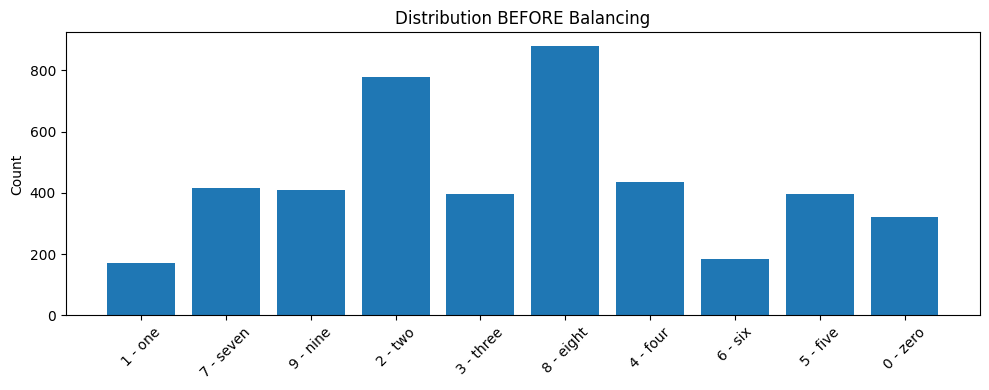

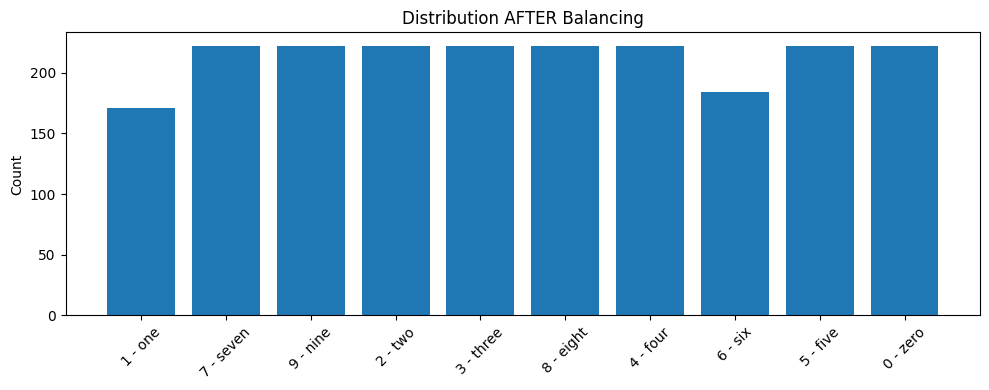

In [64]:
# -------- BEFORE BALANCING ---------
plt.figure(figsize=(10,4))
plt.bar(before_counts.keys(), before_counts.values())
plt.xticks(rotation=45)
plt.title("Distribution BEFORE Balancing")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# -------- AFTER BALANCING ----------
plt.figure(figsize=(10,4))
plt.bar(after_counts.keys(), after_counts.values())
plt.xticks(rotation=45)
plt.title("Distribution AFTER Balancing")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Note: non-digit and ambiguous cases completely overlap with mislabeled, that's why we only end up with 522 labels from the misclassified bucket.

# Creating new dataset with IDK labels

In [65]:
def get_difficult_and_clean_idk_candidates(
    dataset,
    non_digit_view,
    ambig_disagree_view,
    likely_mislabels_view,
    mist_q_difficult=0.999,
    hard_q_difficult=0.999,
):
    """
    Builds:
      - idk_candidate_ids = non_digits ∪ ambiguous_disagreements ∪ likely_mislabels
      - filters out intersection of {very mistaken or very hard} ∩ {likely mislabels}
    analogous to your 'Samples to Filter-out During Fine-tuning' section.

    Returns:
        idk_candidate_ids (set)
        intersection_difficult_misclassified_ids (set)
    """
    non_digit_ids = set(non_digit_view.values("id"))
    ambig_disagreements_ids = set(ambig_disagree_view.values("id"))
    likely_mislabels_ids = set(likely_mislabels_view.values("id"))

    # union of buckets for IDK
    idk_candidate_ids = non_digit_ids.union(ambig_disagreements_ids)
    idk_candidate_ids = idk_candidate_ids.union(likely_mislabels_ids)

    # difficult samples (very high mistakenness or hardness)
    mistakenness_99th = dataset.quantiles("mistakenness", [mist_q_difficult])[0]
    hardness_99th = dataset.quantiles("hardness", [hard_q_difficult])[0]

    highly_mistaken_view = dataset.match(F("mistakenness") > mistakenness_99th)
    highly_hard_view = dataset.match(F("hardness") > hardness_99th)

    highly_mistaken_ids = set(highly_mistaken_view.values("id"))
    highly_hard_ids = set(highly_hard_view.values("id"))

    difficult_samples = highly_mistaken_ids.union(highly_hard_ids)
    misclassified_sample_ids = set(likely_mislabels_view.values("id"))

    intersection_difficult_misclassified_ids = difficult_samples.intersection(misclassified_sample_ids)

    # remove those difficult misclassified samples from IDK pool
    idk_candidate_ids = idk_candidate_ids.difference(intersection_difficult_misclassified_ids)

    print(f"[{dataset.name}] difficult samples (mistakenness/hardness top quantiles): {len(difficult_samples)}")
    print(f"[{dataset.name}] misclassified samples: {len(misclassified_sample_ids)}")
    print(f"[{dataset.name}] intersection difficult ∩ misclassified: {len(intersection_difficult_misclassified_ids)}")
    print(f"[{dataset.name}] final IDK candidates after cleaning: {len(idk_candidate_ids)}")

    return idk_candidate_ids, intersection_difficult_misclassified_ids

In [66]:
train_idk_candidate_ids, intersection_difficult_misclassified_ids = get_difficult_and_clean_idk_candidates(
    train_dataset,
    non_digit_view=refined_non_digits,
    ambig_disagree_view=broad_ambig_disagreements,
    likely_mislabels_view=refined_likely_mislabels,
)

[mnist-training-set] difficult samples (mistakenness/hardness top quantiles): 102
[mnist-training-set] misclassified samples: 188
[mnist-training-set] intersection difficult ∩ misclassified: 56
[mnist-training-set] final IDK candidates after cleaning: 149


In [67]:
def create_curated_idk_dataset(
    source_dataset,
    curated_name,
    idk_candidate_ids,
    intersection_difficult_misclassified_ids,
    idk_label="IDK",
    gt_field="ground_truth",
):
    """
    Clone source_dataset into 'curated_name', delete very difficult+misclassified samples,
    and relabel IDK candidates with 'IDK' in the ground_truth field.

    Returns:
        curated_dataset (fo.Dataset)
    """
    # delete old if exists
    if curated_name in fo.list_datasets():
        fo.delete_dataset(curated_name)
        print(f"Existing dataset '{curated_name}' deleted.")

    curated_dataset = source_dataset.clone(curated_name)
    print(f"Cloned '{source_dataset.name}' to '{curated_name}'.")

    # delete difficult+misclassified intersection
    if intersection_difficult_misclassified_ids:
        curated_dataset.delete_samples(intersection_difficult_misclassified_ids)

    # relabel IDK candidates
    idk_samples_to_relabel = curated_dataset.select(list(idk_candidate_ids))
    count_relabel_idk = 0
    for sample in idk_samples_to_relabel:
        gt = getattr(sample, gt_field, None)
        if gt is not None and hasattr(gt, "label"):
            gt.label = idk_label
            sample[gt_field] = gt
        else:
            sample[gt_field] = fo.Classification(label=idk_label)
        sample.save()
        count_relabel_idk += 1

    print(f"[{curated_name}] Relabeled {count_relabel_idk} ({(count_relabel_idk/len(curated_dataset))*100}%) samples as '{idk_label}'.")
    curated_dataset.persistent = True

    print(f"\nLabel distribution in '{curated_name}':")
    print(curated_dataset.group_by(f"{gt_field}.label").count())

    return curated_dataset

In [68]:
# 1. Choose a new name for your curated dataset
curated_train_name = "mnist_train_curated_idk_class"

curated_train_dataset = create_curated_idk_dataset(
    source_dataset=train_dataset,
    curated_name=curated_train_name,
    idk_candidate_ids=train_idk_candidate_ids,
    intersection_difficult_misclassified_ids=intersection_difficult_misclassified_ids,
)

Cloned 'mnist-training-set' to 'mnist_train_curated_idk_class'.
[mnist_train_curated_idk_class] Relabeled 149 (0.2924780150753769%) samples as 'IDK'.

Label distribution in 'mnist_train_curated_idk_class':
11


In [69]:
# includes new 'IDK' class
label_map_idk = label_map.copy()
label_map_idk['IDK'] = 10

In [70]:
idx_to_label_idk = {v: k for k, v in label_map_idk.items()}

In [71]:
torch_tmp_curated_train_dataset = CustomTorchImageDataset(
    curated_train_dataset,
    label_map=label_map_idk,
    image_transforms=image_transforms
)

CustomTorchImageDataset initialized with 50944 samples.


## Augmenting Examples with clear digits but model uncertainty:


In [72]:
# Install the augmentations plugin
!fiftyone plugins download https://github.com/jacobmarks/fiftyone-albumentations-plugin


Skipping existing plugin '@jacobmarks/albumentations_augmentation'


In [73]:
mnist_augmentations_1 = A.Compose([

    # Use Affine transform for shifting, scaling, and rotating
    A.Affine(
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # ±10% translation
        scale=(0.9, 1.1),     # ±10% scaling
        rotate=(-5, 5),     # ±5° rotation
        p=0.8
    ),

    # Elastic deformations to simulate handwriting style variations
    A.ElasticTransform(
        alpha=20,             # Strength of distortion
        sigma=5,              # Smoothness of distortion
        border_mode=cv2.BORDER_CONSTANT,
        p=0.6
    ),

    # Mild perspective transformations
    A.Perspective(scale=(0.01, 0.03), p=0.2),

    # Mild grid distortion
    A.GridDistortion(num_steps=2, distort_limit=0.05, p=0.2),

])

### Create the torch Dataset for the Augmented Set

In [74]:
class AugmentedMNISTDataset(Dataset):
    """
    PyTorch dataset that applies augmentations to misclassified MNIST samples.
    Each sample can be augmented multiple times to create more training data.
    """

    def __init__(self, fiftyone_view,
                 label_map,
                 base_transforms,
                 augmentations=None,
                 augment_factor=5):
        """
        Args:
            fiftyone_view: FiftyOne view of misclassified samples
            label_map: Mapping from string labels to indices
            base_transforms: Base PyTorch transforms (normalization, etc.)
            augmentations: Albumentations transform pipeline
            augment_factor: How many augmented versions to create per sample
        """
        self.image_paths = fiftyone_view.values("filepath")
        self.str_labels = fiftyone_view.values("ground_truth.label")
        self.label_map = label_map
        self.base_transforms = base_transforms
        self.augmentations = augmentations
        self.augment_factor = augment_factor

        print(f"AugmentedMNISTDataset: {len(self.image_paths)} base samples")
        print(f"With augmentation factor {augment_factor}: {len(self)} total samples")

    def __len__(self):
        return len(self.image_paths) * (self.augment_factor + 1)  # +1 for original

    def __getitem__(self, idx):
        # Determine which base sample and whether to augment
        base_idx = idx // (self.augment_factor + 1)
        aug_idx = idx % (self.augment_factor + 1)

        # Load image
        image_path = self.image_paths[base_idx]
        image = Image.open(image_path).convert('L')

        # Convert to numpy for albumentations
        image_np = np.array(image, dtype=np.uint8)

        # Apply augmentation if not the first version (original)
        if aug_idx > 0 and self.augmentations is not None:
            augmented = self.augmentations(image=image_np)
            image_np = augmented['image']

        # Convert back to PIL for PyTorch transforms
        image = Image.fromarray(image_np).convert("L")

        # Apply base transforms (normalization, tensor conversion)
        if self.base_transforms:
            image = self.base_transforms(image)

        # Get label
        label_str = self.str_labels[base_idx]
        label_idx = self.label_map.get(label_str, -1)

        return image, torch.tensor(label_idx, dtype=torch.long)



In [75]:
rep_q = thresholds["rep_q"]

most_representative = train_dataset.match(F("representativeness") > rep_q)
representative_ids = most_representative.values("id")
print(f"Representative samples: {len(representative_ids)}")

Representative samples: 1090


In [76]:
# Prepares a clean dataset of samples selected for augmentation
# (removes any existing version, then clones the selected subset)

#ids_to_augment = list(set(train_idk_candidate_ids) | set(train_ambig_balanced_ids))
ids_to_augment = list(set(train_ambig_balanced_ids)| set(representative_ids))
augment_samples = curated_train_dataset.select(ids_to_augment)

dataset_name = "digit-samples-to-augment"

if dataset_name in fo.list_datasets():
    print(f"Dataset '{dataset_name}' already exists. Deleting it.")
    fo.delete_dataset(dataset_name)

# Creates a new dataset after deleting or if it didn't exist
dataset_to_augment = augment_samples.clone(name=dataset_name)

dataset_to_augment.save()

In [77]:
torch_augmented_dataset = AugmentedMNISTDataset(
    dataset_to_augment,
    label_map=label_map_idk,
    base_transforms=image_transforms,
    augmentations=mnist_augmentations_1,
    augment_factor=5  # hyperparameter
)

print(f"Total augmented dataset size: {len(torch_augmented_dataset)}")

AugmentedMNISTDataset: 2981 base samples
With augmentation factor 5: 17886 total samples
Total augmented dataset size: 17886


### Integrate new augmented data in curated dataset

In [78]:
# Combine the original dataset with its augmentation
torch_curated_train_dataset = ConcatDataset([torch_tmp_curated_train_dataset, torch_augmented_dataset])
print(f"Combined dataset size: {len(torch_curated_train_dataset)}")

Combined dataset size: 68830


In [79]:
# Create new DataLoader
curated_combined_train_inference_loader = torch.utils.data.DataLoader(
    torch_curated_train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"DataLoader has {len(curated_combined_train_inference_loader)} batches.")

DataLoader has 1076 batches.


In [80]:
# Create a small dataset with original and augmented versions for visualization
def create_augmentation_samples(view, augmentations, num_samples=50):
    """Create FiftyOne samples showing original and augmented versions"""

    dataset_name = "augmented_images_training_set"

    if dataset_name in fo.list_datasets():
        aug_viz_dataset = fo.load_dataset(dataset_name)
    else:
        aug_viz_dataset = fo.Dataset(dataset_name)

    sample_paths = view.values("filepath")[:num_samples]
    sample_labels = view.values("ground_truth.label")[:num_samples]

    for i, (path, label) in enumerate(zip(sample_paths, sample_labels)):
        # Load original image
        original_image = Image.open(path).convert('L')
        original_np = np.array(original_image)

        # Create sample for original image
        original_sample = fo.Sample(filepath=path)
        original_sample.tags = ["original"]
        original_sample["ground_truth"] = fo.Classification(label=label)
        original_sample["augmentation_type"] = "original"
        aug_viz_dataset.add_sample(original_sample)

        # Create 3 augmented versions
        for aug_idx in range(3):
            # Apply augmentation
            augmented = augmentations(image=original_np)['image']

            # Save augmented image temporarily
            aug_image = Image.fromarray(augmented).convert("L")
            temp_path = f"/tmp/aug_{i}_{aug_idx}.png"
            aug_image.save(temp_path)

            # Create FiftyOne sample for augmented image
            aug_sample = fo.Sample(filepath=temp_path)
            aug_sample.tags = ["augmented"]
            aug_sample["ground_truth"] = fo.Classification(label=label)
            aug_sample["augmentation_type"] = f"augmented_{aug_idx + 1}"
            aug_sample["original_sample_id"] = str(i)

            aug_viz_dataset.add_sample(aug_sample)

    return aug_viz_dataset

print("Creating augmentation visualization dataset...")

# Create the visualization dataset
aug_viz_dataset = create_augmentation_samples(
    dataset_to_augment,
    mnist_augmentations_1,
    num_samples=50
)

print(f"Created visualization dataset with {len(aug_viz_dataset)} samples")
print(f"Original samples: {len(aug_viz_dataset.match_tags('original'))}")
print(f"Augmented samples: {len(aug_viz_dataset.match_tags('augmented'))}")

# Launch FiftyOne App to visualize the augmentations
# session.view = aug_viz_dataset.view()

print(f"\nAugmentation Visualization URL: {session.url}")

Creating augmentation visualization dataset...
Created visualization dataset with 200 samples
Original samples: 50
Augmented samples: 150

Augmentation Visualization URL: https://5151-gpu-t4-s-2hn9x7x09rhqr-a.us-west4-0.prod.colab.dev?polling=true


## Creating IDK validation dataset
The validation set is curated using the same ambiguity-based strategy as the training set, but without any augmentation.
This curation is performed once before active learning begins, and the resulting IDK-annotated validation set is then frozen and kept unchanged throughout all active-learning rounds.

In [81]:
print("Applying best LeNet model to the validation set...")
# Set the loaded model to evaluation mode
lenet10_model.eval()

# Store predictions and logits
val_predictions, val_all_logits = create_preds_and_logits(val_loader, lenet10_model, type="val")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications for validation set...")

for i, sample in enumerate(val_dataset):
    # Get the predicted class index and corresponding class name
    predicted_idx = val_predictions[i]
    predicted_label = dataset_classes[predicted_idx]

    # Get logits for this sample
    sample_logits = val_all_logits[i]

    # Calculate confidence scores (softmax applied to logits)
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])

    # Create FiftyOne Classification object with prediction
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()  # Store raw logits
    )

    # Store the Classification object in the sample
    sample["lenet_val_classification"] = classification

    sample.save()

print("Predictions and logits stored successfully as FiftyOne Classifications for validation set.")

Applying best LeNet model to the validation set...
Applying LeNet model to the dataset (using non-shuffled loader)...


Processing val batches for inference: 100%|██████████| 141/141 [00:05<00:00, 27.30it/s]


Inference on {type} dataset complete.
Shape of collected logits: (9000, 10)
Number of collected predictions: 9000
Storing predictions and logits as FiftyOne Classifications for validation set...
Predictions and logits stored successfully as FiftyOne Classifications for validation set.


In [82]:
# Hardness: entropy of predicted probabilities
fob.compute_hardness(
    val_dataset,
    label_field="lenet_val_classification",
)

# Mistakenness: likelihood labels are wrong (uses probs + GT)
fob.compute_mistakenness(
    val_dataset,
    pred_field="lenet_val_classification",
    label_field="ground_truth",
)

# Uniqueness: outlierness in embedding space (needs embeddings)
fob.compute_uniqueness(
    val_dataset,
    embeddings='lenet_embeddings',
)


Computing hardness...


INFO:fiftyone.brain.internal.core.hardness:Computing hardness...


 100% |███████████████| 9000/9000 [18.5s elapsed, 0s remaining, 528.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 9000/9000 [18.5s elapsed, 0s remaining, 528.4 samples/s]      


Hardness computation complete


INFO:fiftyone.brain.internal.core.hardness:Hardness computation complete


Computing mistakenness...


INFO:fiftyone.brain.internal.core.mistakenness:Computing mistakenness...


 100% |███████████████| 9000/9000 [16.4s elapsed, 0s remaining, 622.0 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 9000/9000 [16.4s elapsed, 0s remaining, 622.0 samples/s]      


Mistakenness computation complete


INFO:fiftyone.brain.internal.core.mistakenness:Mistakenness computation complete


INFO:fiftyone.core.models:Downloading model from Google Drive ID '1SIO9XreK0w1ja4EuhBWcR10CnWxCOsom'...


 100% |████|  100.6Mb/100.6Mb [221.0ms elapsed, 0s remaining, 455.0Mb/s]      


INFO:eta.core.utils: 100% |████|  100.6Mb/100.6Mb [221.0ms elapsed, 0s remaining, 455.0Mb/s]      


Computing embeddings...


INFO:fiftyone.brain.internal.core.utils:Computing embeddings...


 100% |███████████████| 9000/9000 [18.3s elapsed, 0s remaining, 545.8 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 9000/9000 [18.3s elapsed, 0s remaining, 545.8 samples/s]      


Computing uniqueness...


INFO:fiftyone.brain.internal.core.uniqueness:Computing uniqueness...


Uniqueness computation complete


INFO:fiftyone.brain.internal.core.uniqueness:Uniqueness computation complete


In [83]:
val_views = get_ambiguity_views(
    val_dataset,
    pred_field="lenet_val_classification",
    thresholds=thresholds,
)
val_non_digits = val_views["non_digit_candidates"]
val_likely_mislabels = val_views["likely_mislabels"]
val_ambig_disagreements = val_views["ambig_disagreements"]
val_ambig_matches_keepaugment = val_views["ambig_matches_keepaugment"]

[mnist-validation-set] missclassified non_digit_candidates: 36
[mnist-validation-set] likely_mislabels: 136
[mnist-validation-set] ambig_disagreements: 0
[mnist-validation-set] ambig_matches_keepaugment: 7575


In [90]:
# After you've stored `lenet_embeddings` on val/test
fob.compute_similarity(
    val_dataset,
    embeddings="lenet_embeddings",
    brain_key="lenet_cosine_similarity_index_val",  # new key
    backend="sklearn",
    metric="cosine",
)

In [84]:
view = val_dataset.select(val_likely_mislabels)
session.view = view
session.refresh()
print(session.url)

https://5151-gpu-t4-s-2hn9x7x09rhqr-a.us-west4-0.prod.colab.dev?polling=true


In [91]:
refined_val_likely_mislabels = refine_likely_mislabels_with_neighbors(
    val_likely_mislabels,
    full_dataset=val_dataset,
    brain_key="lenet_cosine_similarity_index_val",
    k=k_neighbours,
)

Refining 136 likely_mislabels with neighbor info...
Refined 136 → 28 strong mislabels


In [85]:
hard_field = "hardness"

val_ambig_matches_keepaugment_hard = (
    val_ambig_matches_keepaugment
    .sort_by(hard_field, reverse=True)
    .limit(100)
)

In [92]:
refined_val_non_digits = refine_non_digits_with_neighbors(
    val_non_digits,
    full_dataset=val_dataset,
    brain_key="lenet_cosine_similarity_index_val",
    k=k_neighbours,
)

Refining 36 non_digit_candidates with neighbor info...
Refined 36 → 14 strong non-digit / ambiguous candidates


In [93]:
view = val_dataset.select(val_idk_candidates)
session.view = view
session.refresh()
print(session.url)

https://5151-gpu-t4-s-2hn9x7x09rhqr-a.us-west4-0.prod.colab.dev?polling=true


In [94]:
val_idk_candidate_ids, val_intersection_diff_mis = get_difficult_and_clean_idk_candidates(
    val_dataset,
    non_digit_view=refined_val_non_digits,
    ambig_disagree_view=val_ambig_disagreements,
    likely_mislabels_view=refined_val_likely_mislabels,
)

[mnist-validation-set] difficult samples (mistakenness/hardness top quantiles): 18
[mnist-validation-set] misclassified samples: 28
[mnist-validation-set] intersection difficult ∩ misclassified: 9
[mnist-validation-set] final IDK candidates after cleaning: 33


In [95]:
curated_val_name   = "mnist_val_curated_idk_class"

curated_val_dataset = create_curated_idk_dataset(
    source_dataset=val_dataset,
    curated_name=curated_val_name,
    idk_candidate_ids=val_idk_candidate_ids,
    intersection_difficult_misclassified_ids=val_intersection_diff_mis,
)

Cloned 'mnist-validation-set' to 'mnist_val_curated_idk_class'.
[mnist_val_curated_idk_class] Relabeled 33 (0.3670337003670337%) samples as 'IDK'.

Label distribution in 'mnist_val_curated_idk_class':
11


In [96]:
torch_curated_val_dataset = CustomTorchImageDataset(
    curated_val_dataset,
    label_map=label_map_idk,
    image_transforms=image_transforms,
)

CustomTorchImageDataset initialized with 8991 samples.


# Training IDK models

### Compute class_weights
Compute class-frequency statistics and derive class_weights to counteract imbalance introduced by removing, relabeling, and augmenting samples. The IDK class weight is capped to prevent it from dominating training. These weights will be used for both the sampler and the loss function.

In [97]:
def get_train_labels(inference_loader):

  # Extract all labels from the dataset
  all_labels = []
  for _, y in inference_loader:
      all_labels.append(y)

  train_labels = torch.cat(all_labels).cpu().numpy()   # shape [N]

  return train_labels


In [98]:
def plot_class_distribution(labels):
  #Checking class distribution of new dataset
  unique, counts = np.unique(train_labels, return_counts=True)

  plt.figure(figsize=(8,5))
  plt.bar(unique, counts)
  plt.xlabel("Class label")
  plt.ylabel("Count")
  plt.title("Class distribution in combined dataset")
  plt.xticks(unique)
  plt.show()

In [99]:
# Computes inverse-frequency class weights for the curated 11-class setup.
# Rare classes get higher weight; IDK weight is capped to avoid overpowering.
# Returns per-sample weights for the sampler and per-class weights for loss.

g = torch.Generator()
g.manual_seed(SEED)

def compute_class_weights(train_labels):
  IDK_CLASS = label_map_idk["IDK"]
  max_idk_factor = 5.0   # IDK <= 5x average non-IDK weight
  num_classes = NUM_CLASSES_IDK

  # Handle class imbalance
  # Count how many samples per class
  class_counts = np.bincount(train_labels, minlength=NUM_CLASSES_IDK)

  # Inverse-frequency class weights (upsample rare classes)
  class_weights = class_counts.sum() / (class_counts + 1e-6)
  class_weights = class_weights / class_weights.mean()  # normalize

  # Clip IDK weight
  non_idk_mask = np.arange(num_classes) != IDK_CLASS
  mean_non_idk = class_weights[non_idk_mask].mean()

  class_weights[IDK_CLASS] = min(
      class_weights[IDK_CLASS],
      max_idk_factor * mean_non_idk,
  )

  # Weight per sample = weight of its class
  sample_weights = class_weights[train_labels]
  sample_weights = torch.from_numpy(sample_weights).double()

  return sample_weights, class_weights


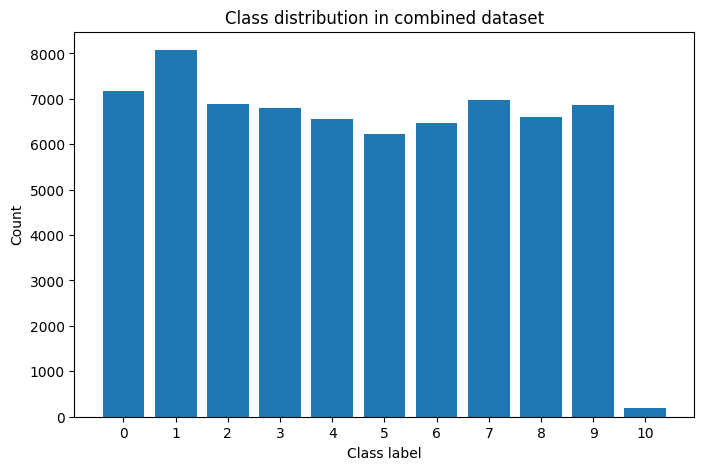

In [100]:
train_labels = get_train_labels(curated_combined_train_inference_loader)
plot_class_distribution(train_labels)
sample_weights, class_weights = compute_class_weights(train_labels)

In [101]:
# using a WeightedRandomSampler
class_balancing_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # The total number of samples to draw per epoch
    replacement=True,  # Usually True for oversampling minority classes
    generator=g
)

In [102]:
al_val_loader = torch.utils.data.DataLoader(
    torch_curated_val_dataset,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)

In [103]:
curated_train_weighted_loader = torch.utils.data.DataLoader(
    torch_curated_train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    sampler=class_balancing_sampler
)

## Train model with 11 classes (incl. idk label)

In [104]:
# Create and Train IDK model
lenet_idk_model = ModernLeNet5(num_classes=NUM_CLASSES_IDK).to(device)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

lr=0.003
betas=(0.9, 0.999)
eps=1e-08
weight_decay=0
num_epochs = 10

# Define the optimizer (variant of stochastic gradient descent)
optimizer = Adam(lenet_idk_model.parameters(),
                 lr=lr, betas=betas,
                 eps=eps, weight_decay=weight_decay)

# Ensure reproducibility for the training process
set_seeds(SEED)

train_losses = []
val_losses = []

# Define the path to save the model to hard-drive
model_save_path = CKPT_DIR / "al_lenet11_mnist.pth"

print(f"Starting training for {num_epochs} epochs...")
train_losses, val_losses = train_model(lenet_idk_model, curated_train_weighted_loader, al_val_loader, optimizer, criterion, num_epochs, model_save_path)



All random seeds set to 51 for reproducibility
Starting training for 10 epochs...


Validation: 100%|██████████| 141/141 [00:03<00:00, 42.79it/s]


Epoch 1/10 - Train Loss: 0.5553 - Val Loss: 0.1211
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 43.35it/s]


Epoch 2/10 - Train Loss: 0.3009 - Val Loss: 0.1213


Validation: 100%|██████████| 141/141 [00:03<00:00, 43.34it/s]


Epoch 3/10 - Train Loss: 0.2337 - Val Loss: 0.1220


Validation: 100%|██████████| 141/141 [00:04<00:00, 32.46it/s]


Epoch 4/10 - Train Loss: 0.1933 - Val Loss: 0.1556


Validation: 100%|██████████| 141/141 [00:05<00:00, 26.11it/s]


Epoch 5/10 - Train Loss: 0.1625 - Val Loss: 0.1677


Validation: 100%|██████████| 141/141 [00:03<00:00, 43.94it/s]


Epoch 6/10 - Train Loss: 0.1562 - Val Loss: 0.1902


Validation: 100%|██████████| 141/141 [00:03<00:00, 44.28it/s]


Epoch 7/10 - Train Loss: 0.1531 - Val Loss: 0.2021


Validation: 100%|██████████| 141/141 [00:03<00:00, 39.34it/s]


Epoch 8/10 - Train Loss: 0.1410 - Val Loss: 0.2398


Validation: 100%|██████████| 141/141 [00:05<00:00, 26.92it/s]


Epoch 9/10 - Train Loss: 0.1398 - Val Loss: 0.2225


Validation: 100%|██████████| 141/141 [00:03<00:00, 44.14it/s]

Epoch 10/10 - Train Loss: 0.1228 - Val Loss: 0.2266


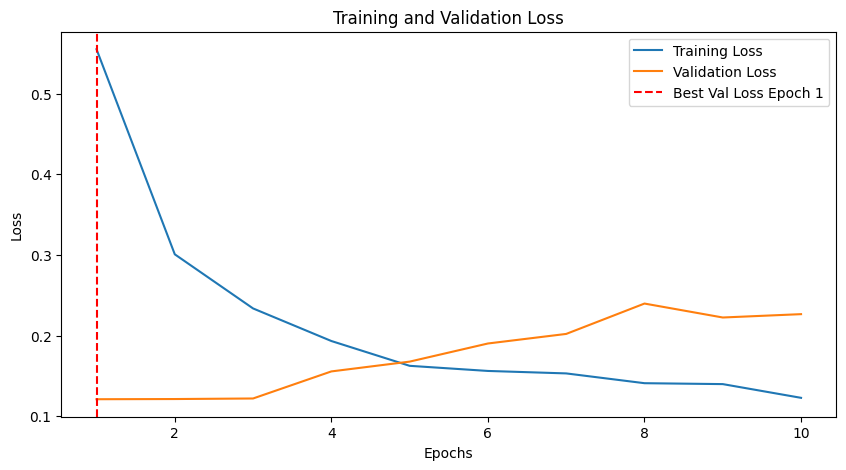

In [105]:
plot_losses(train_losses, val_losses, num_epochs)

## Fine-tune IDK (11 class model) on existing 10 class model

In [106]:
# Load Best 10class Model for Retraining

# Ensure reproducibility for the retraining process
set_seeds(SEED)

# Load the trained 10-class model
model_save_path = CKPT_DIR / "lenet10_mnist.pth"
base_model = ModernLeNet5(num_classes=NUM_CLASSES)
base_model.load_state_dict(torch.load(model_save_path, map_location=device))
base_model = base_model.to(device)
base_model.eval()

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Create a fresh 11-class model
idk_model_retrained = ModernLeNet5(num_classes=NUM_CLASSES_IDK).to(device)


# Copy all weights except the final classifier (fc2)
state_10 = base_model.state_dict()
state_11 = idk_model_retrained.state_dict()

for name, param in state_10.items():
    if "fc2" not in name:               # skip final layer (different output size)
        if name in state_11:
            state_11[name] = param

idk_model_retrained.load_state_dict(state_11)
print("Loaded 10-class weights into 11-class model (except final layer).")


# Freeze all layers except the new classifier
for name, p in idk_model_retrained.named_parameters():
    p.requires_grad = ("fc2" in name)   # train only fc2

# Optimizer + Loss
retrain_optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, idk_model_retrained.parameters()),
    lr=0.0002, weight_decay=1e-3)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

print("11-class IDK model ready for training.")

# Retrain model
retrain_epochs = 15
retrain_losses = []
retrain_val_losses = []
retrain_model_save_path = CKPT_DIR / 'lenet11_retrained_mnist.pth'

print(f"Starting training for {retrain_epochs} epochs...")
retrain_losses, retrain_val_losses = train_model(idk_model_retrained,
                                                 curated_train_weighted_loader, al_val_loader, retrain_optimizer,
                                                 criterion, retrain_epochs, retrain_model_save_path
                                                 )

print(f"\nRetraining complete! Best model saved to {retrain_model_save_path}")


All random seeds set to 51 for reproducibility
Loaded 10-class weights into 11-class model (except final layer).
11-class IDK model ready for training.
Starting training for 15 epochs...


Validation: 100%|██████████| 141/141 [00:03<00:00, 43.03it/s]


Epoch 1/15 - Train Loss: 0.9406 - Val Loss: 0.1063
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:04<00:00, 34.19it/s]


Epoch 2/15 - Train Loss: 0.4231 - Val Loss: 0.0877
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:04<00:00, 28.71it/s]


Epoch 3/15 - Train Loss: 0.3623 - Val Loss: 0.0813
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 43.32it/s]


Epoch 4/15 - Train Loss: 0.3488 - Val Loss: 0.0788
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 42.47it/s]


Epoch 5/15 - Train Loss: 0.3417 - Val Loss: 0.0779
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:05<00:00, 27.86it/s]


Epoch 6/15 - Train Loss: 0.3323 - Val Loss: 0.0779


Validation: 100%|██████████| 141/141 [00:03<00:00, 35.87it/s]


Epoch 7/15 - Train Loss: 0.3210 - Val Loss: 0.0770
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 43.22it/s]


Epoch 8/15 - Train Loss: 0.3199 - Val Loss: 0.0765
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 39.50it/s]


Epoch 9/15 - Train Loss: 0.3181 - Val Loss: 0.0757
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:04<00:00, 32.59it/s]


Epoch 10/15 - Train Loss: 0.3251 - Val Loss: 0.0752
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:03<00:00, 43.83it/s]


Epoch 11/15 - Train Loss: 0.3211 - Val Loss: 0.0756


Validation: 100%|██████████| 141/141 [00:03<00:00, 36.49it/s]


Epoch 12/15 - Train Loss: 0.3191 - Val Loss: 0.0745
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:04<00:00, 30.45it/s]


Epoch 13/15 - Train Loss: 0.3239 - Val Loss: 0.0755


Validation: 100%|██████████| 141/141 [00:03<00:00, 43.68it/s]


Epoch 14/15 - Train Loss: 0.3191 - Val Loss: 0.0750


Validation: 100%|██████████| 141/141 [00:03<00:00, 41.58it/s]

Epoch 15/15 - Train Loss: 0.3173 - Val Loss: 0.0746

Retraining complete! Best model saved to /content/drive/MyDrive/Colab Notebooks/Applied Computer Vision Projects/Project01/models/lenet11_retrained_mnist.pth


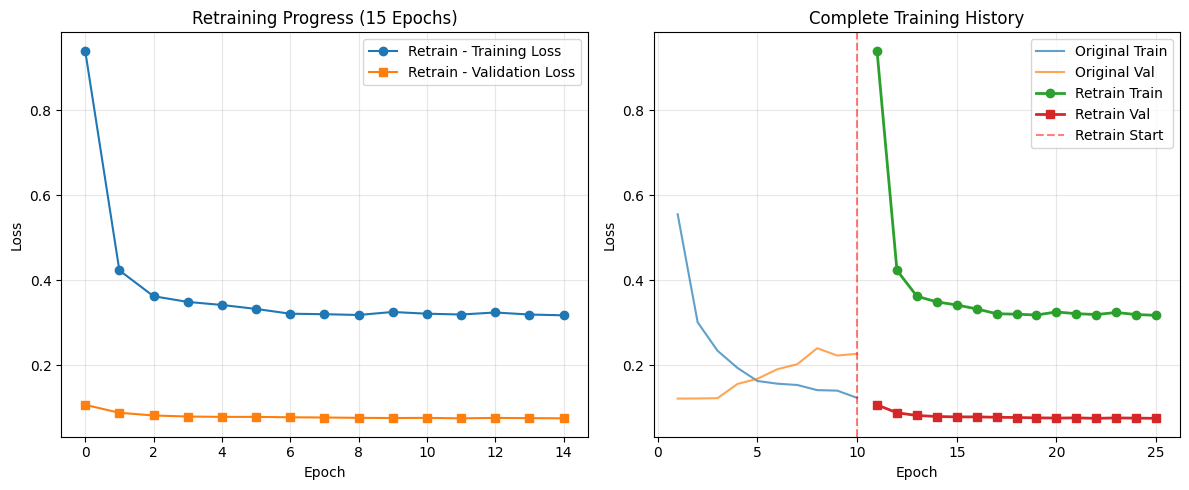

In [107]:
plt.figure(figsize=(12, 5))

# Plot retraining losses
plt.subplot(1, 2, 1)
plt.plot(retrain_losses, label='Retrain - Training Loss', marker='o')
plt.plot(retrain_val_losses, label='Retrain - Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Retraining Progress ({retrain_epochs} Epochs)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot comparison with original training (if we have the data)
plt.subplot(1, 2, 2)
if 'train_losses' in locals() and 'val_losses' in locals():
    epochs_orig = range(1, len(train_losses) + 1)
    epochs_retrain = range(len(train_losses) + 1, len(train_losses) + 1 + len(retrain_losses))

    plt.plot(epochs_orig, train_losses, label='Original Train', alpha=0.7)
    plt.plot(epochs_orig, val_losses, label='Original Val', alpha=0.7)
    plt.plot(epochs_retrain, retrain_losses, label='Retrain Train', marker='o', linewidth=2)
    plt.plot(epochs_retrain, retrain_val_losses, label='Retrain Val', marker='s', linewidth=2)

    plt.axvline(x=len(train_losses), color='red', linestyle='--', alpha=0.5, label='Retrain Start')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Complete Training History')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluation on test set

## Creating IDK test set

In [108]:
fob.compute_hardness(
    test_dataset,
    label_field="lenet_classification",
)
fob.compute_mistakenness(
    test_dataset,
    pred_field="lenet_classification",
    label_field="ground_truth",
)
fob.compute_uniqueness(
    test_dataset,
    embeddings="lenet_embeddings",
)

Computing hardness...


INFO:fiftyone.brain.internal.core.hardness:Computing hardness...


 100% |█████████████| 10000/10000 [20.0s elapsed, 0s remaining, 532.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [20.0s elapsed, 0s remaining, 532.5 samples/s]      


Hardness computation complete


INFO:fiftyone.brain.internal.core.hardness:Hardness computation complete


Computing mistakenness...


INFO:fiftyone.brain.internal.core.mistakenness:Computing mistakenness...


 100% |█████████████| 10000/10000 [17.9s elapsed, 0s remaining, 475.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [17.9s elapsed, 0s remaining, 475.3 samples/s]      


Mistakenness computation complete


INFO:fiftyone.brain.internal.core.mistakenness:Mistakenness computation complete


Computing embeddings...


INFO:fiftyone.brain.internal.core.utils:Computing embeddings...


 100% |█████████████| 10000/10000 [20.7s elapsed, 0s remaining, 401.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [20.7s elapsed, 0s remaining, 401.3 samples/s]      


Computing uniqueness...


INFO:fiftyone.brain.internal.core.uniqueness:Computing uniqueness...


Uniqueness computation complete


INFO:fiftyone.brain.internal.core.uniqueness:Uniqueness computation complete


In [109]:
test_views = get_ambiguity_views(
    test_dataset,
    pred_field="lenet_classification",
    thresholds=thresholds,
)
test_non_digits = test_views["non_digit_candidates"]
test_likely_mislabels = test_views["likely_mislabels"]
test_ambig_disagreements = test_views["ambig_disagreements"]
test_ambig_matches_keepaugment = test_views["ambig_matches_keepaugment"]

[mnist-test] missclassified non_digit_candidates: 34
[mnist-test] likely_mislabels: 128
[mnist-test] ambig_disagreements: 0
[mnist-test] ambig_matches_keepaugment: 8146


In [110]:
test_idk_candidate_ids, test_intersection_diff_mis = get_difficult_and_clean_idk_candidates(
    test_dataset,
    non_digit_view=test_non_digits,
    ambig_disagree_view=test_ambig_disagreements,
    likely_mislabels_view=test_likely_mislabels,
)

[mnist-test] difficult samples (mistakenness/hardness top quantiles): 20
[mnist-test] misclassified samples: 128
[mnist-test] intersection difficult ∩ misclassified: 17
[mnist-test] final IDK candidates after cleaning: 111


In [111]:
curated_test_name  = "mnist_test_curated_idk_class"

curated_test_dataset = create_curated_idk_dataset(
    source_dataset=test_dataset,
    curated_name=curated_test_name,
    idk_candidate_ids=test_idk_candidate_ids,
    intersection_difficult_misclassified_ids=test_intersection_diff_mis,
)

Cloned 'mnist-test' to 'mnist_test_curated_idk_class'.
[mnist_test_curated_idk_class] Relabeled 111 (1.1118902133627167%) samples as 'IDK'.

Label distribution in 'mnist_test_curated_idk_class':
11


In [112]:
torch_curated_test_dataset = CustomTorchImageDataset(
    curated_test_dataset,
    label_map=label_map_idk,
    image_transforms=image_transforms,
)

CustomTorchImageDataset initialized with 9983 samples.


## Evaluate Model Performance

In [113]:
idk_test_loader = torch.utils.data.DataLoader(
    torch_curated_test_dataset,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)

## Evaluate IDK (11 class) model

- Train models - save best / done
- reload best model
- compute classification object (logits/predictions) on test set
- Store Retrained Model Predictions in FiftyOne: Output is classification object = “retrained_lenet_classification”
- Evaluate Retrained Model Performance

In [115]:
### Load best model
model_save_path = CKPT_DIR / "al_lenet11_mnist.pth"
loaded_idk_class_model = ModernLeNet5(num_classes=NUM_CLASSES_IDK)
loaded_idk_class_model.load_state_dict(torch.load(model_save_path, map_location=device))
loaded_idk_class_model = loaded_idk_class_model.to(device)
loaded_idk_class_model.eval()

print(f"Model loaded successfully from {model_save_path}")
print(f"Model is on device: {next(loaded_idk_class_model.parameters()).device}")

Model loaded successfully from /content/drive/MyDrive/Colab Notebooks/Applied Computer Vision Projects/Project01/models/al_lenet11_mnist.pth
Model is on device: cuda:0


In [116]:
### Collect predictions and logits in arrays for analysis.
idk_class_predictions = []
idk_class_logits = []

with torch.inference_mode():
    for images, _ in tqdm(idk_test_loader, desc="Evaluating idk model"):
        images = images.to(device)

        logits = loaded_idk_class_model(images)
        idk_class_logits.append(logits.cpu().numpy())

        _, predicted = torch.max(logits.data, 1)
        idk_class_predictions.extend(predicted.cpu().numpy())

# Concatenate all results
idk_class_logits = np.concatenate(idk_class_logits, axis=0)

print(f"idk class model evaluation complete.")
print(f"Predictions shape: {len(idk_class_predictions)}")
print(f"Logits shape: {idk_class_logits.shape}")

Evaluating idk model: 100%|██████████| 156/156 [00:03<00:00, 42.35it/s]

idk class model evaluation complete.
Predictions shape: 9983
Logits shape: (9983, 11)


In [117]:
### Store Model Predictions in FiftyOne
print("Storing idk class model predictions in FiftyOne...")

for i, sample in enumerate(tqdm(curated_test_dataset, desc="Storing idk predictions")):
    predicted_idx = idk_class_predictions[i]
    predicted_label = idx_to_label_idk[predicted_idx]
    sample_logits = idk_class_logits[i]

    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])

    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()
    )

    sample["idk_class_lenet_classification"] = classification
    sample.save()

print("idk class model predictions stored successfully!")



Storing idk class model predictions in FiftyOne...


Storing idk predictions: 100%|██████████| 9983/9983 [00:28<00:00, 353.94it/s]

idk class model predictions stored successfully!


In [118]:
print("\nEvaluating  idk class model performance...")

# Evaluate retrained model
idk_class_evaluation_results = curated_test_dataset.evaluate_classifications(
    "idk_class_lenet_classification",
    gt_field="ground_truth",
    eval_key="idk_class_lenet_eval"
)

print("\n" + "="*60)
print("IDK CLASS MODEL EVALUATION RESULTS")
print("="*60)
idk_class_evaluation_results.print_report(digits=4)



Evaluating  idk class model performance...

IDK CLASS MODEL EVALUATION RESULTS
              precision    recall  f1-score   support

    0 - zero     0.9949    0.9908    0.9928       976
     1 - one     0.9991    0.9797    0.9893      1131
     2 - two     0.9845    0.9883    0.9864      1028
   3 - three     0.9850    0.9840    0.9845      1002
    4 - four     0.9597    0.9917    0.9754       960
    5 - five     0.9853    0.9876    0.9865       885
     6 - six     0.9822    0.9947    0.9884       945
   7 - seven     0.9823    0.9823    0.9823      1016
   8 - eight     0.9583    0.9937    0.9757       949
    9 - nine     0.9661    0.9888    0.9773       980
         IDK     0.3000    0.0811    0.1277       111

    accuracy                         0.9779      9983
   macro avg     0.9179    0.9057    0.9060      9983
weighted avg     0.9726    0.9779    0.9744      9983



In [119]:
# Find samples that were misclassified before but correct now
originally_wrong = curated_test_dataset.match(
    F("lenet_classification.label") != F("ground_truth.label")
)

now_correct = originally_wrong.match(
    F("idk_class_lenet_classification.label") == F("ground_truth.label")
)

print(f"\nSamples fixed by retraining: {len(now_correct)}")

# Find samples that were correct before but wrong now
originally_correct = curated_test_dataset.match(
    F("lenet_classification.label") == F("ground_truth.label")
)

now_wrong = originally_correct.match(
    F("idk_class_lenet_classification.label") != F("ground_truth.label")
)

print(f"Samples broken by retraining: {len(now_wrong)}")

# Net improvement
net_improvement = len(now_correct) - len(now_wrong)
print(f"Net improvement in correct predictions: {net_improvement}")


Samples fixed by retraining: 9
Samples broken by retraining: 119
Net improvement in correct predictions: -110


### Evaluate fine-tuned IDK (11 class) model

In [120]:
### Load best model
model_save_path = CKPT_DIR / "lenet11_retrained_mnist.pth"
loaded_idk_retrained_model = ModernLeNet5(num_classes=NUM_CLASSES_IDK)
loaded_idk_retrained_model.load_state_dict(torch.load(model_save_path, map_location=device))
loaded_idk_retrained_model = loaded_idk_retrained_model.to(device)
loaded_idk_retrained_model.eval()

print(f"Model loaded successfully from {model_save_path}")
print(f"Model is on device: {next(loaded_idk_retrained_model.parameters()).device}")

Model loaded successfully from /content/drive/MyDrive/Colab Notebooks/Applied Computer Vision Projects/Project01/models/lenet11_retrained_mnist.pth
Model is on device: cuda:0


In [121]:
### Collect predictions and logits in arrays for analysis.
idk_retrained_predictions = []
idk_retrained_logits = []

with torch.inference_mode():
    for images, _ in tqdm(idk_test_loader, desc="Evaluating idk model"):
        images = images.to(device)

        logits = loaded_idk_retrained_model(images)
        idk_retrained_logits.append(logits.cpu().numpy())

        _, predicted = torch.max(logits.data, 1)
        idk_retrained_predictions.extend(predicted.cpu().numpy())

# Concatenate all results
idk_retrained_logits = np.concatenate(idk_retrained_logits, axis=0)

print(f"idk retrained model evaluation complete.")
print(f"Predictions shape: {len(idk_retrained_predictions)}")
print(f"Logits shape: {idk_retrained_logits.shape}")

Evaluating idk model: 100%|██████████| 156/156 [00:03<00:00, 42.49it/s]

idk retrained model evaluation complete.
Predictions shape: 9983
Logits shape: (9983, 11)


In [122]:
### Store Model Predictions in FiftyOne
print("Storing idk retrained model predictions in FiftyOne...")
idx_to_label_idk = {v: k for k, v in label_map_idk.items()}

for i, sample in enumerate(tqdm(curated_test_dataset, desc="Storing idk predictions")):
    predicted_idx = idk_retrained_predictions[i]
    predicted_label = idx_to_label_idk[predicted_idx]
    sample_logits = idk_retrained_logits[i]

    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])

    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()
    )

    sample["idk_retrained_lenet_classification"] = classification
    sample.save()

print("idk retrained model predictions stored successfully!")



Storing idk retrained model predictions in FiftyOne...


Storing idk predictions: 100%|██████████| 9983/9983 [00:31<00:00, 312.82it/s]

idk retrained model predictions stored successfully!


In [123]:
print("\nEvaluating idk retrained model performance...")

# Evaluate retrained model
idk_retrained_evaluation_results = curated_test_dataset.evaluate_classifications(
    "idk_retrained_lenet_classification",
    gt_field="ground_truth",
    eval_key="idk_retrained_lenet_eval"
)

print("\n" + "="*60)
print("IDK RETRAINED MODEL EVALUATION RESULTS")
print("="*60)
idk_retrained_evaluation_results.print_report(digits=4)



Evaluating idk retrained model performance...

IDK RETRAINED MODEL EVALUATION RESULTS
              precision    recall  f1-score   support

    0 - zero     0.9969    0.9990    0.9980       976
     1 - one     0.9956    0.9982    0.9969      1131
     2 - two     0.9951    0.9961    0.9956      1028
   3 - three     0.9901    1.0000    0.9950      1002
    4 - four     0.9866    1.0000    0.9933       960
    5 - five     0.9888    0.9989    0.9938       885
     6 - six     0.9926    0.9989    0.9958       945
   7 - seven     0.9825    0.9970    0.9897      1016
   8 - eight     0.9824    1.0000    0.9911       949
    9 - nine     0.9780    0.9980    0.9879       980
         IDK     0.7333    0.0991    0.1746       111

    accuracy                         0.9886      9983
   macro avg     0.9657    0.9168    0.9192      9983
weighted avg     0.9862    0.9886    0.9847      9983



In [124]:
# Find samples that were misclassified before but correct now
originally_wrong = curated_test_dataset.match(
    F("lenet_classification.label") != F("ground_truth.label")
)

now_correct = originally_wrong.match(
    F("idk_retrained_lenet_classification.label") == F("ground_truth.label")
)

print(f"\nSamples fixed by retraining: {len(now_correct)}")

# Find samples that were correct before but wrong now
originally_correct = curated_test_dataset.match(
    F("lenet_classification.label") == F("ground_truth.label")
)

now_wrong = originally_correct.match(
    F("idk_retrained_lenet_classification.label") != F("ground_truth.label")
)

print(f"Samples broken by retraining: {len(now_wrong)}")

# Net improvement
net_improvement = len(now_correct) - len(now_wrong)
print(f"Net improvement in correct predictions: {net_improvement}")


Samples fixed by retraining: 11
Samples broken by retraining: 14
Net improvement in correct predictions: -3


### Compare model performance across IDK models

In [125]:
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

# Get metrics for both models
original_metrics = lenet_evaluation_results.metrics()
retrained_metrics = idk_retrained_evaluation_results.metrics()

print(f"{'Metric':<20} {'Original':<12} {'Retrained':<12} {'Improvement':<12}")
print("-" * 56)

metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1']

for metric in metrics_to_compare:
    if metric in original_metrics and metric in retrained_metrics:
        orig_val = original_metrics[metric]
        retrain_val = retrained_metrics[metric]
        improvement = retrain_val - orig_val

        print(f"{metric:<20} {orig_val:<12.4f} {retrain_val:<12.4f} {improvement:+.4f}")




PERFORMANCE COMPARISON
Metric               Original     Retrained    Improvement 
--------------------------------------------------------
accuracy             0.9872       0.9886       +0.0014
precision            0.9872       0.9886       +0.0014
recall               0.9872       0.9886       +0.0014


### Q1: Forced decision performance (digits only)

If both models must output a digit for every test sample, which model is more accurate, and is the improvement consistent across classes?

Evaluate
* Accuracy on digits 0–9
* Macro-F1 on digits (ignore IDK)
* Per-digit precision/recall
* Confusion matrix (10-digit part)

For this:
* Baseline model: trained on original MNIST train (10 classes)
* IDK model: trained on curated+augmented train (11 classes incl. IDK)
* Evaluation: both are evaluated on the same original test set (10 digits only)

The IDK model will be forced to we forced to output a digit by ignoring the IDK logit



In [126]:
def evaluate_digit_only_models(
    baseline_model,
    idk_model,
    test_loader,
    device,
    idk_class_index=10,
    ignore_gt_idk=True,
):
    """
    Compare a 10-class baseline model vs. an 11-class (IDK) model
    when both are forced to output a digit (0-9) for every test sample.

    Parameters
    ----------
    baseline_model : torch.nn.Module
        10-class classifier (digits 0-9).
    idk_model : torch.nn.Module
        11-class classifier (digits 0-9 + IDK).
    test_loader : DataLoader
        Yields (images, labels). Labels may include IDK class.
    device : torch.device
        e.g., torch.device("cuda") or torch.device("cpu").
    idk_class_index : int, optional
        Index of the IDK class in the 11-class model. Default: 10.
    ignore_gt_idk : bool, optional
        If True, samples whose ground truth is IDK are excluded
        from evaluation. Default: True.

    Returns
    -------
    metrics : dict
        Contains accuracy, macro-F1, per-class precision/recall/F1,
        and confusion matrices for both models.
    """
    baseline_model.eval()
    idk_model.eval()

    all_labels = []
    baseline_preds = []
    idk_digit_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Optionally ignore samples whose ground truth is IDK
            if ignore_gt_idk:
                mask = labels != idk_class_index
                if mask.sum() == 0:
                    continue
                images = images[mask]
                labels = labels[mask]

            # ---- Baseline model (10 classes) ----
            logits_base = baseline_model(images)           # [B, 10]
            preds_base = torch.argmax(logits_base, dim=1)  # digit 0-9

            # ---- IDK model (11 classes) ----
            logits_idk = idk_model(images)                 # [B, 11]

            # Force a digit prediction by ignoring the IDK logit:
            # take argmax only over digit logits 0-9
            digit_logits = logits_idk[:, :10]              # [B, 10]
            preds_idk_digits = torch.argmax(digit_logits, dim=1)  # 0-9

            # Collect for metric computation
            all_labels.append(labels.detach().cpu())
            baseline_preds.append(preds_base.detach().cpu())
            idk_digit_preds.append(preds_idk_digits.detach().cpu())

    # Concatenate all batches
    y_true = torch.cat(all_labels).numpy()
    y_pred_base = torch.cat(baseline_preds).numpy()
    y_pred_idk = torch.cat(idk_digit_preds).numpy()

    # ---- Overall accuracy ----
    acc_base = accuracy_score(y_true, y_pred_base)
    acc_idk = accuracy_score(y_true, y_pred_idk)

    # ---- Macro-F1 (digits only) ----
    macro_f1_base = f1_score(y_true, y_pred_base, average="macro")
    macro_f1_idk = f1_score(y_true, y_pred_idk, average="macro")

    # ---- Per-digit precision/recall/F1 ----
    digits = list(range(10))  # 0-9
    pr_base, rc_base, f1_base, _ = precision_recall_fscore_support(
        y_true, y_pred_base, labels=digits, zero_division=0
    )
    pr_idk, rc_idk, f1_idk, _ = precision_recall_fscore_support(
        y_true, y_pred_idk, labels=digits, zero_division=0
    )

    # ---- Confusion matrices (10x10) ----
    cm_base = confusion_matrix(y_true, y_pred_base, labels=digits)
    cm_idk = confusion_matrix(y_true, y_pred_idk, labels=digits)

    metrics = {
        "y_true": y_true,
        "baseline": {
            "accuracy": acc_base,
            "macro_f1": macro_f1_base,
            "precision": pr_base,
            "recall": rc_base,
            "f1": f1_base,
            "confusion_matrix": cm_base,
        },
        "idk_model_forced_digit": {
            "accuracy": acc_idk,
            "macro_f1": macro_f1_idk,
            "precision": pr_idk,
            "recall": rc_idk,
            "f1": f1_idk,
            "confusion_matrix": cm_idk,
        },
    }

    return metrics

In [128]:
base_model.to(device)
loaded_idk_retrained_model.to(device)

metrics = evaluate_digit_only_models(
    baseline_model=base_model,
    idk_model=loaded_idk_retrained_model,
    test_loader=test_loader,
    device=device,
    idk_class_index=10,
    ignore_gt_idk=True,
)

print("=== Overall metrics (forced digit) ===")
print(f"Baseline   – Accuracy: {metrics['baseline']['accuracy']:.4f}, "
      f"Macro-F1: {metrics['baseline']['macro_f1']:.4f}")
print(f"IDK model – Accuracy: {metrics['idk_model_forced_digit']['accuracy']:.4f}, "
      f"Macro-F1: {metrics['idk_model_forced_digit']['macro_f1']:.4f}")

print("\n=== Per-digit precision / recall / F1 (Baseline) ===")
for d, (p, r, f) in enumerate(
    zip(metrics["baseline"]["precision"],
        metrics["baseline"]["recall"],
        metrics["baseline"]["f1"])
):
    print(f"Digit {d}: P={p:.3f}, R={r:.3f}, F1={f:.3f}")

print("\n=== Per-digit precision / recall / F1 (IDK model, forced digit) ===")
for d, (p, r, f) in enumerate(
    zip(metrics["idk_model_forced_digit"]["precision"],
        metrics["idk_model_forced_digit"]["recall"],
        metrics["idk_model_forced_digit"]["f1"])
):
    print(f"Digit {d}: P={p:.3f}, R={r:.3f}, F1={f:.3f}")

print("\n=== Confusion matrix (Baseline, rows=true, cols=pred) ===")
print(metrics["baseline"]["confusion_matrix"])

print("\n=== Confusion matrix (IDK model, rows=true, cols=pred) ===")
print(metrics["idk_model_forced_digit"]["confusion_matrix"])

=== Overall metrics (forced digit) ===
Baseline   – Accuracy: 0.9872, Macro-F1: 0.9871
IDK model – Accuracy: 0.9902, Macro-F1: 0.9901

=== Per-digit precision / recall / F1 (Baseline) ===
Digit 0: P=0.993, R=0.996, F1=0.994
Digit 1: P=0.990, R=0.996, F1=0.993
Digit 2: P=0.981, R=0.996, F1=0.988
Digit 3: P=0.988, R=0.992, F1=0.990
Digit 4: P=0.994, R=0.978, F1=0.986
Digit 5: P=0.974, R=0.992, F1=0.983
Digit 6: P=0.993, R=0.986, F1=0.990
Digit 7: P=0.980, R=0.988, F1=0.984
Digit 8: P=0.995, R=0.974, F1=0.984
Digit 9: P=0.985, R=0.971, F1=0.978

=== Per-digit precision / recall / F1 (IDK model, forced digit) ===
Digit 0: P=0.994, R=0.995, F1=0.994
Digit 1: P=0.994, R=0.996, F1=0.995
Digit 2: P=0.993, R=0.993, F1=0.993
Digit 3: P=0.989, R=0.994, F1=0.992
Digit 4: P=0.993, R=0.985, F1=0.989
Digit 5: P=0.984, R=0.991, F1=0.988
Digit 6: P=0.994, R=0.989, F1=0.991
Digit 7: P=0.986, R=0.992, F1=0.989
Digit 8: P=0.992, R=0.987, F1=0.989
Digit 9: P=0.983, R=0.980, F1=0.982

=== Confusion matrix (

**Interpretation:**
When both models are forced to output a digit (0–9) for every test sample, the IDK-augmented model is slightly more accurate than the baseline (0.9902 vs. 0.9872) and also achieves a higher macro-F1 (0.9901 vs. 0.9871). The per-digit precision/recall scores show small, consistent improvements across nearly all classes.

Overall, incorporating the IDK class and curated training data does not harm digit recognition; instead, it yields a modest and uniform performance gain across the digit classes which could get better with increased learning rounds.

### Q2: Selective classification: accuracy vs coverage (abstention performance)

Does the IDK model fail more gracefully than the 10-class model by abstaining on uncertain samples?

To test whether the IDK model “fails more gracefully,” we evaluate both models using selective classification.
Evaluate
* Sweep threshold τ on max softmax probability → abstain if pmax < τ otherwise predict a digit
* Plot accuracy vs coverage curves

Additionally for the 11-class model:
* Evaluate “explicit IDK” without threshold

If the IDK model's curve shows higher accuracy at the same coverage (or the explicit-IDK point lies high on the curve), then the model truly handles uncertainty better—i.e., it avoids wrong predictions by abstaining on the hard cases.

In [129]:
def collect_logits_on_curated_test(
    baseline_model,
    idk_model,
    curated_test_loader,
    device,
):
    """
    Runs both models on the curated test set and collects:
    - y_true: ground truth labels (0..10)
    - logits_10: baseline model logits (N, 10)
    - logits_11: IDK model logits (N, 11)
    """
    baseline_model.eval()
    idk_model.eval()

    all_labels = []
    all_logits_10 = []
    all_logits_11 = []

    with torch.no_grad():
        for images, labels in curated_test_loader:
            images = images.to(device)
            labels = labels.to(device)

            logits_10 = baseline_model(images)   # [B,10]
            logits_11 = idk_model(images)        # [B,11]

            all_labels.append(labels.cpu())
            all_logits_10.append(logits_10.cpu())
            all_logits_11.append(logits_11.cpu())

    y_true = torch.cat(all_labels).numpy()
    logits_10 = torch.cat(all_logits_10).numpy()
    logits_11 = torch.cat(all_logits_11).numpy()

    return y_true, logits_10, logits_11

In [130]:
def accuracy_coverage_curve_from_logits(logits, y_true, tau_values):
    """
    Given logits (N, C) and true labels (N,),
    compute accuracy vs coverage for thresholds in tau_values.

    We:
      - compute softmax over classes
      - pmax = max probability
      - abstain if pmax < tau

    Returns:
      coverage: np.array shape (len(tau_values),)
      accuracy: np.array shape (len(tau_values),)
    """
    # softmax probabilities
    probs = Fun.softmax(torch.from_numpy(logits), dim=1).numpy()
    pmax = probs.max(axis=1)
    preds = probs.argmax(axis=1)

    N = len(y_true)
    coverages = []
    accuracies = []

    for tau in tau_values:
        mask = pmax >= tau  # True = keep, False = abstain
        covered = np.where(mask)[0]

        coverage = mask.mean()  # fraction of non-abstained samples
        if coverage > 0:
            acc = (preds[covered] == y_true[covered]).mean()
        else:
            acc = np.nan

        coverages.append(coverage)
        accuracies.append(acc)

    return np.array(coverages), np.array(accuracies)

In [131]:
def explicit_idk_point(logits_11, y_true, idk_class_index=10):
    """
    Treat predicted IDK as abstain, everything else as a prediction.

    Returns (coverage, accuracy):
      - coverage = fraction of samples where pred != IDK
      - accuracy = accuracy on non-IDK predictions
    """
    probs_11 = Fun.softmax(torch.from_numpy(logits_11), dim=1).numpy()
    preds_11 = probs_11.argmax(axis=1)

    mask_covered = preds_11 != idk_class_index
    covered_idx = np.where(mask_covered)[0]

    coverage = mask_covered.mean()
    if coverage > 0:
        acc = (preds_11[covered_idx] == y_true[covered_idx]).mean()
    else:
        acc = np.nan

    return coverage, acc

In [132]:
base_model.to(device)
loaded_idk_retrained_model.to(device)

# 1) Collect logits once
y_true, logits_10, logits_11 = collect_logits_on_curated_test(
    base_model,
    loaded_idk_retrained_model,
    idk_test_loader,
    device,
)

# 2) Define threshold grid
tau_values = np.linspace(0.0, 1.0, 21)  # e.g. 0.0, 0.05, ..., 1.0

# 3) Baseline 10-class: threshold on pmax
cov_base, acc_base = accuracy_coverage_curve_from_logits(
    logits_10, y_true, tau_values
)

# 4) 11-class: threshold on pmax (ignoring IDK semantics)
cov_idk_soft, acc_idk_soft = accuracy_coverage_curve_from_logits(
    logits_11, y_true, tau_values
)

# 5) 11-class: explicit IDK (single point)
cov_idk_explicit, acc_idk_explicit = explicit_idk_point(
    logits_11, y_true, idk_class_index=10
)

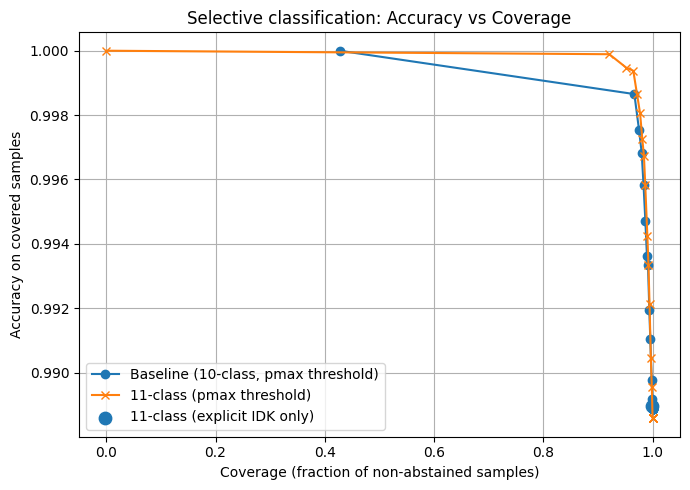

In [133]:
plt.figure(figsize=(7, 5))

# Baseline: pmax threshold
plt.plot(cov_base, acc_base, marker='o', label="Baseline (10-class, pmax threshold)")

# 11-class: pmax threshold
plt.plot(cov_idk_soft, acc_idk_soft, marker='x', label="11-class (pmax threshold)")

# explicit IDK (single point)
plt.scatter([cov_idk_explicit], [acc_idk_explicit], s=80, label="11-class (explicit IDK only)")

plt.xlabel("Coverage (fraction of non-abstained samples)")
plt.ylabel("Accuracy on covered samples")
plt.title("Selective classification: Accuracy vs Coverage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation:**
The 11-class model achieves higher accuracy at the same coverage than the 10-class baseline, showing that it discards uncertain samples more effectively. The explicit-IDK point also lies high on the curve, indicating that the learned IDK head meaningfully captures difficult cases. Overall, the IDK-trained model fails more gracefully by abstaining on harder inputs rather than misclassifying them.

### Q3: IDK class quality (precision/recall against curated IDK ground truth)

This evaluation checks whether the IDK model truly detects ambiguous samples better than the 10-class model using a low-confidence heuristic.

1. 11-class model (explicit IDK)
We treat the output as binary: IDK if the model predicts the IDK class, digit otherwise

2. 10-class model (low confidence)
The baseline cannot output IDK, so we simulate it:
IDK if 𝑝_max < 𝜏, digit otherwise

Evaluation: Precision, Recall, F1

Tells us whether an explicit IDK class improves uncertainty detection more than simple softmax thresholding.

In [134]:
def evaluate_idk_quality(
    baseline_model,
    idk_model,
    curated_test_loader,
    device,
    idk_class_index=10,
    low_conf_threshold=0.5,
):
    """
    Compare IDK detection quality between:
    - 11-class IDK model (explicit IDK output)
    - 10-class baseline model (implicit IDK via low confidence)

    Parameters
    ----------
    baseline_model : nn.Module
        10-class classifier (digits 0-9).
    idk_model : nn.Module
        11-class classifier (digits 0-9 + IDK).
    curated_test_loader : DataLoader
        Yields (images, labels) with labels in {0,...,10}, where
        `idk_class_index` is the IDK ground-truth label.
    device : torch.device
        e.g. torch.device("cuda") or torch.device("cpu").
    idk_class_index : int, optional
        Index used for IDK label in the 11-class setup. Default: 10.
    low_conf_threshold : float, optional
        Threshold τ: if p_max < τ, the 10-class model is treated
        as predicting IDK. Default: 0.5.

    Returns
    -------
    results : dict
        {
          "threshold": τ,
          "n_samples": ...,
          "n_true_idk": ...,
          "idk_model": { "precision": ..., "recall": ..., "f1": ... },
          "baseline_lowconf": { "precision": ..., "recall": ..., "f1": ... },
        }
    """
    baseline_model.eval()
    idk_model.eval()

    all_true_idk = []
    all_pred_idk_11 = []
    all_pred_idk_10 = []

    with torch.no_grad():
        for images, labels in curated_test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # --- Ground truth: IDK vs digit ---
            # 1 = IDK, 0 = digit (0-9)
            true_idk = (labels == idk_class_index).long()

            # --- 11-class model (explicit IDK) ---
            logits_11 = idk_model(images)          # [B, 11]
            preds_11 = torch.argmax(logits_11, dim=1)  # [B]
            pred_idk_11 = (preds_11 == idk_class_index).long()

            # --- 10-class model (implicit IDK via low confidence) ---
            logits_10 = baseline_model(images)     # [B, 10]
            probs_10 = Fun.softmax(logits_10, dim=1)
            pmax_10, _ = torch.max(probs_10, dim=1)

            # If pmax < τ -> treat as IDK
            pred_idk_10 = (pmax_10 < low_conf_threshold).long()

            # Collect
            all_true_idk.append(true_idk.cpu())
            all_pred_idk_11.append(pred_idk_11.cpu())
            all_pred_idk_10.append(pred_idk_10.cpu())

    y_true = torch.cat(all_true_idk).numpy()          # 0/1
    y_pred_11 = torch.cat(all_pred_idk_11).numpy()    # 0/1
    y_pred_10 = torch.cat(all_pred_idk_10).numpy()    # 0/1

    # Sanity counts
    n_samples = len(y_true)
    n_true_idk = int((y_true == 1).sum())

    # We treat "1" as the positive class (IDK = positive)
    p_11, r_11, f1_11, _ = precision_recall_fscore_support(
        y_true, y_pred_11, average="binary", pos_label=1, zero_division=0
    )
    p_10, r_10, f1_10, _ = precision_recall_fscore_support(
        y_true, y_pred_10, average="binary", pos_label=1, zero_division=0
    )

    results = {
        "threshold": low_conf_threshold,
        "n_samples": n_samples,
        "n_true_idk": n_true_idk,
        "idk_model": {
            "precision": p_11,
            "recall": r_11,
            "f1": f1_11,
        },
        "baseline_lowconf": {
            "precision": p_10,
            "recall": r_10,
            "f1": f1_10,
        },
    }

    return results


In [135]:
base_model.to(device)
loaded_idk_retrained_model.to(device)

# Choose a threshold τ for low confidence -> IDK
tau = 0.5   # you can later try 0.4, 0.6, etc.

results = evaluate_idk_quality(
    baseline_model=base_model,
    idk_model=loaded_idk_class_model,
    curated_test_loader=idk_test_loader,
    device=device,
    idk_class_index=10,          # adjust if your IDK label index differs
    low_conf_threshold=tau,
)

print(f"Total samples in curated test set: {results['n_samples']}")
print(f"Number of true IDK samples:       {results['n_true_idk']}")
print(f"Low-confidence threshold tau:     {results['threshold']}")

print("\n=== 11-class IDK model (explicit IDK) ===")
print(f"IDK Precision: {results['idk_model']['precision']:.3f}")
print(f"IDK Recall:    {results['idk_model']['recall']:.3f}")
print(f"IDK F1:        {results['idk_model']['f1']:.3f}")

print("\n=== 10-class baseline (pmax < tau => IDK) ===")
print(f"IDK Precision: {results['baseline_lowconf']['precision']:.3f}")
print(f"IDK Recall:    {results['baseline_lowconf']['recall']:.3f}")
print(f"IDK F1:        {results['baseline_lowconf']['f1']:.3f}")

Total samples in curated test set: 9983
Number of true IDK samples:       111
Low-confidence threshold tau:     0.5

=== 11-class IDK model (explicit IDK) ===
IDK Precision: 0.300
IDK Recall:    0.081
IDK F1:        0.128

=== 10-class baseline (pmax < tau => IDK) ===
IDK Precision: 0.500
IDK Recall:    0.081
IDK F1:        0.140


**Interpretation**:
The explicit 11-class IDK model and the confidence-based baseline achieve the same low IDK recall because the IDK class is still severely underrepresented in training.

Its precision is lower due to more false IDK predictions, and thus the baseline’s simple confidence-threshold heuristic attains a slightly higher F1-score. This indicates that additional active-learning rounds are needed for the IDK head to become well-calibrated.

# Curate Validation and Test Set one last time with the final 11 class model

# Save the curated MNIST sets to your hard drive

In [136]:
# We list the datasets that we have available on this session.
fo.list_datasets()

['augmented_images_training_set',
 'digit-samples-to-augment',
 'mnist-test',
 'mnist-train-val',
 'mnist-training-set',
 'mnist-validation-set',
 'mnist_test_curated_idk_class',
 'mnist_train_curated_idk_class',
 'mnist_val_curated_idk_class']

In [ ]:
# Load the three separate datasets
train_dataset = fo.load_dataset("mnist_train_curated_idk_class")
val_dataset = fo.load_dataset("mnist_val_curated_idk_class")
test_dataset = fo.load_dataset("mnist_test_curated_idk_class")

# Create a new merged dataset
merged_dataset = fo.Dataset("curated-mnist")

# Add training samples with split tag
for sample in train_dataset:
    sample.tags.append("train")
    merged_dataset.add_sample(sample)

# Add validation samples with split tag
for sample in val_dataset:
    sample.tags.append("validation")
    merged_dataset.add_sample(sample)

# Add test samples with split tag
for sample in test_dataset:
    sample.tags.append("test")
    merged_dataset.add_sample(sample)

# Save the merged dataset
merged_dataset.persistent = True

print(f"Merged dataset created with {len(merged_dataset)} total samples")
print(f"Train samples: {len(merged_dataset.match_tags('train'))}")
print(f"Validation samples: {len(merged_dataset.match_tags('validation'))}")
print(f"Test samples: {len(merged_dataset.match_tags('test'))}")

In [ ]:
# Put all models in a subfolder
CKPT_DIR = ROOT / "dataset"
CKPT_DIR.mkdir(exist_ok=True)

export_dir = CKPT_DIR / "curated_mnist_fiftyone"
export_dir.mkdir(parents=True, exist_ok=True)

merged_dataset.export(
    export_dir=str(export_dir),
    dataset_type=fo.types.FiftyOneDataset,
    export_media=True  # This exports the actual image files along with metadata
)

print(f"Merged dataset exported to: {export_dir}")
print(f"Total samples exported: {len(merged_dataset)}")